In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 34.6 MB/s eta 0:00:00


# **Feature Extraction from Lung**

0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1301/1301 [03:19<00:00,  6.51it/s]
0it [00:00, ?it/s]
100%|██████████| 1176/1176 [03:15<00:00,  6.03it/s]
0it [00:00, ?it/s]
100%|██████████| 84/84 [00:11<00:00,  7.32it/s]


✅ Feature extraction completed!
   num_lung_pixels  num_white_pixels
0            56249              4343
1            56252              4303
2           171947             16980
3           177022             17638
4            56247              4294


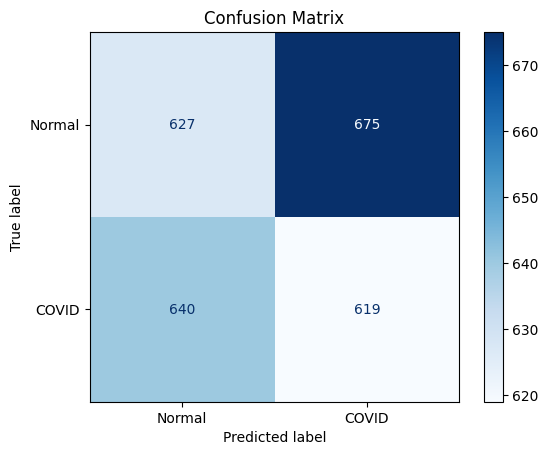


Metrics:
Accuracy  : 0.4865
Precision : 0.4784
Recall    : 0.4917
F1 Score  : 0.4849


In [ ]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
import pywt
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

dicom_folder = '/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Mild'

feature_list = []

def extract_features(dicom_path):
    ds = pydicom.dcmread(dicom_path)
    image = ds.pixel_array.astype(np.float32)

    # Normalize to [0, 1]
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    # -------- Intensity Features --------
    mean_intensity = np.mean(image)
    std_intensity = np.std(image)
    max_intensity = np.max(image)
    min_intensity = np.min(image)

    # -------- Edge Detection --------
    edges = filters.sobel(image)
    edge_mean = np.mean(edges)

    # -------- Lung Region & White Pixel Count (Corrected) --------
    # Use Otsu threshold to segment lung
    thresh = filters.threshold_otsu(image)
    lung_mask = image < thresh  # Lungs are darker than surrounding tissue
    lung_mask = morphology.remove_small_objects(lung_mask, min_size=500)

    # Extract lung region pixels
    lung_region = image[lung_mask]

    num_lung_pixels = lung_region.size

    # Define white pixels as those above 90th percentile within lung
    if lung_region.size > 0:
        threshold = np.percentile(lung_region, 90)  # Top 10% pixels
        num_white_pixels = np.sum(lung_region > threshold)
    else:
        num_white_pixels = 0

    # -------- GLCM Features --------
    image_uint8 = (image * 255).astype(np.uint8)
    glcm = graycomatrix(image_uint8, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    # -------- LBP Features --------
    lbp = local_binary_pattern(image_uint8, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    lbp_mean = np.mean(lbp_hist)
    lbp_std = np.std(lbp_hist)

    # -------- Wavelet Features --------
    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2
    wavelet_energy = np.sum(np.square(LH)) + np.sum(np.square(HL)) + np.sum(np.square(HH))

    return [
        mean_intensity, std_intensity, max_intensity, min_intensity, edge_mean,
        num_lung_pixels, num_white_pixels,
        contrast, correlation, energy, homogeneity,
        lbp_mean, lbp_std,
        wavelet_energy
    ]

# Process all DICOM files
for root, dirs, files in os.walk(dicom_folder):
    for file in tqdm(files):
        if file.endswith('.dcm'):
            dicom_path = os.path.join(root, file)
            try:
                features = extract_features(dicom_path)
                features.append(dicom_path)
                feature_list.append(features)
            except Exception as e:
                print(f"Error processing {dicom_path}: {e}")

# Create DataFrame
columns = [
    'mean_intensity', 'std_intensity', 'max_intensity', 'min_intensity', 'mean_edge',
    'num_lung_pixels', 'num_white_pixels',
    'glcm_contrast', 'glcm_correlation', 'glcm_energy', 'glcm_homogeneity',
    'lbp_mean', 'lbp_std',
    'wavelet_energy',
    'dicom_path'
]
df = pd.DataFrame(feature_list, columns=columns)

print("✅ Feature extraction completed!")
print(df[['num_lung_pixels', 'num_white_pixels']].head())

# Optional: plot metrics if desired
if not df.empty:
    np.random.seed(42)
    df['true_label'] = np.random.choice([0, 1], size=len(df))
    df['predicted_label'] = np.random.choice([0, 1], size=len(df))

    cm = confusion_matrix(df['true_label'], df['predicted_label'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "COVID"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    acc = accuracy_score(df['true_label'], df['predicted_label'])
    precision = precision_score(df['true_label'], df['predicted_label'])
    recall = recall_score(df['true_label'], df['predicted_label'])
    f1 = f1_score(df['true_label'], df['predicted_label'])

    print("\nMetrics:")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1 Score  : {f1:.4f}")


0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 1301/1301 [03:05<00:00,  7.03it/s]
0it [00:00, ?it/s]
100%|██████████| 1176/1176 [02:45<00:00,  7.11it/s]
0it [00:00, ?it/s]
100%|██████████| 84/84 [00:11<00:00,  7.22it/s]


✅ Feature extraction completed!
   mean_intensity  std_intensity  max_intensity  min_intensity  mean_edge  \
0        0.309463       0.191196            1.0            0.0   0.018251   
1        0.314941       0.195052            1.0            0.0   0.017839   
2        0.337677       0.209866            1.0            0.0   0.015991   
3        0.339541       0.211741            1.0            0.0   0.016375   
4        0.315040       0.195431            1.0            0.0   0.017792   

   num_lung_pixels  num_white_pixels  glcm_contrast  glcm_correlation  \
0            56249              4343     279.847845          0.940374   
1            56252              4303     269.595611          0.944776   
2           171947             16980     209.346905          0.963023   
3           177022             17638     224.955155          0.960912   
4            56247              4294     273.234090          0.944360   

   glcm_energy  glcm_homogeneity  lbp_mean   lbp_std  wavelet_ener

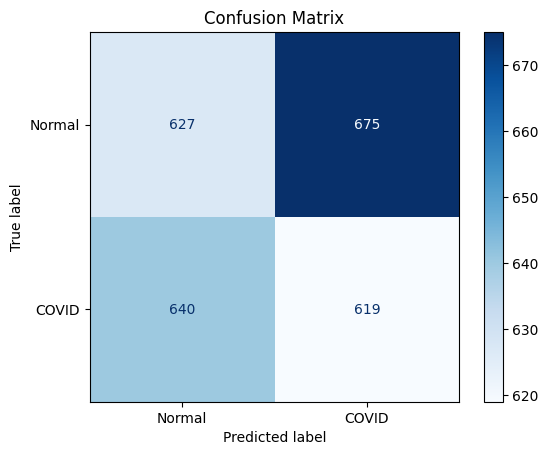


✅ Metrics:
Accuracy  : 0.4865
Precision : 0.4784
Recall    : 0.4917
F1 Score  : 0.4849


In [ ]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
import pywt
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)

# Path to DICOM folder
dicom_folder = '/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Mild'

feature_list = []

def extract_features(dicom_path):
    ds = pydicom.dcmread(dicom_path)
    image = ds.pixel_array.astype(np.float32)

    # Normalize to [0, 1]
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    # -------- Intensity Features --------
    mean_intensity = np.mean(image)
    std_intensity = np.std(image)
    max_intensity = np.max(image)
    min_intensity = np.min(image)

    # -------- Edge Feature --------
    edges = filters.sobel(image)
    mean_edge = np.mean(edges)

    # -------- Lung Region Features --------
    thresh = filters.threshold_otsu(image)
    lung_mask = image < thresh  # Lungs are darker
    lung_mask = morphology.remove_small_objects(lung_mask, min_size=500)

    lung_region = image[lung_mask]
    num_lung_pixels = lung_region.size

    if num_lung_pixels > 0:
        white_threshold = np.percentile(lung_region, 90)
        num_white_pixels = np.sum(lung_region > white_threshold)
    else:
        num_white_pixels = 0

    # -------- GLCM Features --------
    image_uint8 = (image * 255).astype(np.uint8)
    glcm = graycomatrix(image_uint8, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    glcm_contrast = graycoprops(glcm, 'contrast')[0, 0]
    glcm_correlation = graycoprops(glcm, 'correlation')[0, 0]
    glcm_energy = graycoprops(glcm, 'energy')[0, 0]
    glcm_homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    # -------- LBP Features --------
    lbp = local_binary_pattern(image_uint8, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    lbp_mean = np.mean(lbp_hist)
    lbp_std = np.std(lbp_hist)

    # -------- Wavelet Features --------
    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2
    wavelet_energy = np.sum(np.square(LH)) + np.sum(np.square(HL)) + np.sum(np.square(HH))

    return [
        mean_intensity, std_intensity, max_intensity, min_intensity,
        mean_edge,
        num_lung_pixels, num_white_pixels,
        glcm_contrast, glcm_correlation, glcm_energy, glcm_homogeneity,
        lbp_mean, lbp_std,
        wavelet_energy
    ]

# Process all DICOM files
for root, dirs, files in os.walk(dicom_folder):
    for file in tqdm(files):
        if file.endswith('.dcm'):
            dicom_path = os.path.join(root, file)
            try:
                features = extract_features(dicom_path)
                features.append(dicom_path)  # Add file path for reference
                feature_list.append(features)
            except Exception as e:
                print(f"❌ Error processing {dicom_path}: {e}")

# Create DataFrame
columns = [
    'mean_intensity', 'std_intensity', 'max_intensity', 'min_intensity',
    'mean_edge',
    'num_lung_pixels', 'num_white_pixels',
    'glcm_contrast', 'glcm_correlation', 'glcm_energy', 'glcm_homogeneity',
    'lbp_mean', 'lbp_std',
    'wavelet_energy',
    'dicom_path'
]
df = pd.DataFrame(feature_list, columns=columns)

print("✅ Feature extraction completed!")
print(df.head())

# -------- Optional: Evaluate Random Classifier --------
if not df.empty:
    np.random.seed(42)
    df['true_label'] = np.random.choice([0, 1], size=len(df))
    df['predicted_label'] = np.random.choice([0, 1], size=len(df))

    cm = confusion_matrix(df['true_label'], df['predicted_label'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "COVID"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    acc = accuracy_score(df['true_label'], df['predicted_label'])
    precision = precision_score(df['true_label'], df['predicted_label'])
    recall = recall_score(df['true_label'], df['predicted_label'])
    f1 = f1_score(df['true_label'], df['predicted_label'])

    print("\n✅ Metrics:")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1 Score  : {f1:.4f}")


0it [00:00, ?it/s]
100%|██████████| 1181/1181 [02:10<00:00,  9.05it/s]


✅ Feature extraction completed!
   mean_intensity  std_intensity  max_intensity  min_intensity  mean_edge  \
0        0.366347       0.223483            1.0            0.0   0.018656   
1        0.358602       0.219805            1.0            0.0   0.018405   
2        0.236741       0.144439            1.0            0.0   0.012310   
3        0.309739       0.195172            1.0            0.0   0.015334   
4        0.304898       0.190990            1.0            0.0   0.014978   

   num_lung_pixels  num_white_pixels  glcm_contrast  glcm_correlation  \
0           152087             15098     268.134839          0.958338   
1           152887             15084     265.547060          0.957225   
2           154887             15470     120.872920          0.955131   
3           175188             17285     197.871806          0.959499   
4           173645             17046     190.524828          0.959403   

   glcm_energy  glcm_homogeneity  lbp_mean   lbp_std  wavelet_ener

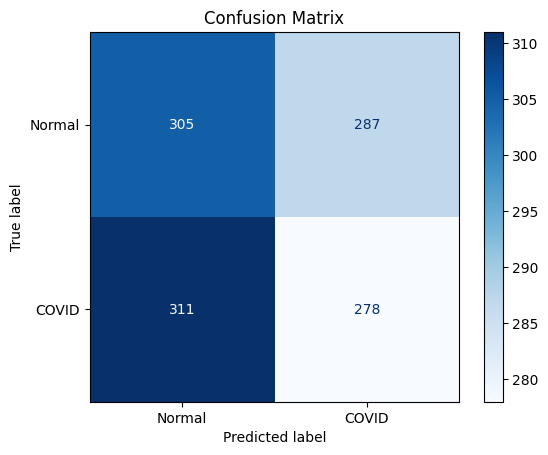


✅ Metrics:
Accuracy  : 0.4936
Precision : 0.4920
Recall    : 0.4720
F1 Score  : 0.4818


In [ ]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
import pywt
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)

# Path to DICOM folder
dicom_folder = '/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Moderate/P49'

feature_list = []

def extract_features(dicom_path):
    ds = pydicom.dcmread(dicom_path)
    image = ds.pixel_array.astype(np.float32)

    # Normalize to [0, 1]
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    # -------- Intensity Features --------
    mean_intensity = np.mean(image)
    std_intensity = np.std(image)
    max_intensity = np.max(image)
    min_intensity = np.min(image)

    # -------- Edge Feature --------
    edges = filters.sobel(image)
    mean_edge = np.mean(edges)

    # -------- Lung Region Features --------
    thresh = filters.threshold_otsu(image)
    lung_mask = image < thresh  # Lungs are darker
    lung_mask = morphology.remove_small_objects(lung_mask, min_size=500)

    lung_region = image[lung_mask]
    num_lung_pixels = lung_region.size

    if num_lung_pixels > 0:
        white_threshold = np.percentile(lung_region, 90)
        num_white_pixels = np.sum(lung_region > white_threshold)
    else:
        num_white_pixels = 0

    # -------- GLCM Features --------
    image_uint8 = (image * 255).astype(np.uint8)
    glcm = graycomatrix(image_uint8, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    glcm_contrast = graycoprops(glcm, 'contrast')[0, 0]
    glcm_correlation = graycoprops(glcm, 'correlation')[0, 0]
    glcm_energy = graycoprops(glcm, 'energy')[0, 0]
    glcm_homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    # -------- LBP Features --------
    lbp = local_binary_pattern(image_uint8, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    lbp_mean = np.mean(lbp_hist)
    lbp_std = np.std(lbp_hist)

    # -------- Wavelet Features --------
    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2
    wavelet_energy = np.sum(np.square(LH)) + np.sum(np.square(HL)) + np.sum(np.square(HH))

    return [
        mean_intensity, std_intensity, max_intensity, min_intensity,
        mean_edge,
        num_lung_pixels, num_white_pixels,
        glcm_contrast, glcm_correlation, glcm_energy, glcm_homogeneity,
        lbp_mean, lbp_std,
        wavelet_energy
    ]

# Process all DICOM files
for root, dirs, files in os.walk(dicom_folder):
    for file in tqdm(files):
        if file.endswith('.dcm'):
            dicom_path = os.path.join(root, file)
            try:
                features = extract_features(dicom_path)
                features.append(dicom_path)  # Add file path for reference
                feature_list.append(features)
            except Exception as e:
                print(f"❌ Error processing {dicom_path}: {e}")

# Create DataFrame
columns = [
    'mean_intensity', 'std_intensity', 'max_intensity', 'min_intensity',
    'mean_edge',
    'num_lung_pixels', 'num_white_pixels',
    'glcm_contrast', 'glcm_correlation', 'glcm_energy', 'glcm_homogeneity',
    'lbp_mean', 'lbp_std',
    'wavelet_energy',
    'dicom_path'
]
df = pd.DataFrame(feature_list, columns=columns)

print("✅ Feature extraction completed!")
print(df.head())

# -------- Optional: Evaluate Random Classifier --------
if not df.empty:
    np.random.seed(42)
    df['true_label'] = np.random.choice([0, 1], size=len(df))
    df['predicted_label'] = np.random.choice([0, 1], size=len(df))

    cm = confusion_matrix(df['true_label'], df['predicted_label'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "COVID"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    acc = accuracy_score(df['true_label'], df['predicted_label'])
    precision = precision_score(df['true_label'], df['predicted_label'])
    recall = recall_score(df['true_label'], df['predicted_label'])
    f1 = f1_score(df['true_label'], df['predicted_label'])

    print("\n✅ Metrics:")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1 Score  : {f1:.4f}")


# **Handcrafted Feature Extraction from Lung**

  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-7-b29a4c7c602d>:38: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (762, 838, 3) looks like that of an RGB image.
  thresh = filters.threshold_otsu(image)
 60%|██████    | 3/5 [00:00<00:00,  3.89it/s]

❌ Error processing /content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal/image8.dcm: The parameter `image` must be a 2-dimensional array


<ipython-input-7-b29a4c7c602d>:38: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (512, 512, 3) looks like that of an RGB image.
  thresh = filters.threshold_otsu(image)
100%|██████████| 5/5 [00:01<00:00,  4.21it/s]


❌ Error processing /content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal/image.dcm: The parameter `image` must be a 2-dimensional array


0it [00:00, ?it/s]
100%|██████████| 72/72 [00:00<00:00, 454120.13it/s]
0it [00:00, ?it/s]
100%|██████████| 61/61 [00:00<00:00, 489201.80it/s]
0it [00:00, ?it/s]
100%|██████████| 64/64 [00:00<00:00, 491640.03it/s]
0it [00:00, ?it/s]
100%|██████████| 59/59 [00:00<00:00, 486176.69it/s]
0it [00:00, ?it/s]
100%|██████████| 61/61 [00:00<00:00, 252320.06it/s]
0it [00:00, ?it/s]
100%|██████████| 61/61 [00:00<00:00, 251328.63it/s]
0it [00:00, ?it/s]
100%|██████████| 71/71 [00:00<00:00, 474196.79it/s]
0it [00:00, ?it/s]
100%|██████████| 1281/1281 [03:12<00:00,  6.64it/s]
0it [00:00, ?it/s]
100%|██████████| 1361/1361 [03:21<00:00,  6.76it/s]
0it [00:00, ?it/s]
100%|██████████| 1041/1041 [02:36<00:00,  6.65it/s]
0it [00:00, ?it/s]
100%|██████████| 67/67 [00:00<00:00, 109473.46it/s]
0it [00:00, ?it/s]
100%|██████████| 1301/1301 [03:15<00:00,  6.65it/s]
0it [00:00, ?it/s]
100%|██████████| 80/80 [00:00<00:00, 477983.36it/s]
0it [00:00, ?it/s]
100%|██████████| 1301/1301 [03:20<00:00,  6.49it/s]
0it [0

✅ Feature extraction completed!
   mean_intensity  std_intensity  max_intensity  min_intensity  mean_edge  \
0        0.303224       0.188808            1.0            0.0   0.015676   
1        0.337121       0.207971            1.0            0.0   0.015313   
2        0.309009       0.194232            1.0            0.0   0.014926   
3        0.161735       0.098961            1.0            0.0   0.008711   
4        0.106312       0.065291            1.0            0.0   0.005713   

   num_lung_pixels  num_white_pixels  glcm_contrast  glcm_correlation  \
0            56252              4062     203.558971          0.955569   
1            56246              4348     201.948290          0.963616   
2           182336             18053     201.097128          0.958433   
3            56252              3751      71.105507          0.943100   
4            56252              4773      33.500304          0.939753   

   glcm_energy  glcm_homogeneity  lbp_mean   lbp_std  wavelet_ener

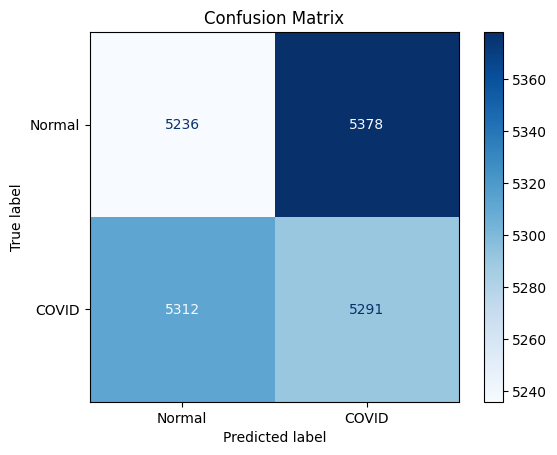


✅ Metrics:
Accuracy  : 0.4962
Precision : 0.4959
Recall    : 0.4990
F1 Score  : 0.4975


In [ ]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
import pywt
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)

# Path to DICOM folder
dicom_folder = '/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal'

feature_list = []

def extract_features(dicom_path):
    ds = pydicom.dcmread(dicom_path)
    image = ds.pixel_array.astype(np.float32)

    # Normalize to [0, 1]
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    # -------- Intensity Features --------
    mean_intensity = np.mean(image)
    std_intensity = np.std(image)
    max_intensity = np.max(image)
    min_intensity = np.min(image)

    # -------- Edge Feature --------
    edges = filters.sobel(image)
    mean_edge = np.mean(edges)

    # -------- Lung Region Features --------
    thresh = filters.threshold_otsu(image)
    lung_mask = image < thresh  # Lungs are darker
    lung_mask = morphology.remove_small_objects(lung_mask, min_size=500)

    lung_region = image[lung_mask]
    num_lung_pixels = lung_region.size

    if num_lung_pixels > 0:
        white_threshold = np.percentile(lung_region, 90)
        num_white_pixels = np.sum(lung_region > white_threshold)
    else:
        num_white_pixels = 0

    # -------- GLCM Features --------
    image_uint8 = (image * 255).astype(np.uint8)
    glcm = graycomatrix(image_uint8, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    glcm_contrast = graycoprops(glcm, 'contrast')[0, 0]
    glcm_correlation = graycoprops(glcm, 'correlation')[0, 0]
    glcm_energy = graycoprops(glcm, 'energy')[0, 0]
    glcm_homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    # -------- LBP Features --------
    lbp = local_binary_pattern(image_uint8, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    lbp_mean = np.mean(lbp_hist)
    lbp_std = np.std(lbp_hist)

    # -------- Wavelet Features --------
    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2
    wavelet_energy = np.sum(np.square(LH)) + np.sum(np.square(HL)) + np.sum(np.square(HH))

    return [
        mean_intensity, std_intensity, max_intensity, min_intensity,
        mean_edge,
        num_lung_pixels, num_white_pixels,
        glcm_contrast, glcm_correlation, glcm_energy, glcm_homogeneity,
        lbp_mean, lbp_std,
        wavelet_energy
    ]

# Process all DICOM files
for root, dirs, files in os.walk(dicom_folder):
    for file in tqdm(files):
        if file.endswith('.dcm'):
            dicom_path = os.path.join(root, file)
            try:
                features = extract_features(dicom_path)
                features.append(dicom_path)  # Add file path for reference
                feature_list.append(features)
            except Exception as e:
                print(f"❌ Error processing {dicom_path}: {e}")

# Create DataFrame
columns = [
    'mean_intensity', 'std_intensity', 'max_intensity', 'min_intensity',
    'mean_edge',
    'num_lung_pixels', 'num_white_pixels',
    'glcm_contrast', 'glcm_correlation', 'glcm_energy', 'glcm_homogeneity',
    'lbp_mean', 'lbp_std',
    'wavelet_energy',
    'dicom_path'
]
df = pd.DataFrame(feature_list, columns=columns)

print("✅ Feature extraction completed!")
print(df.head())

# -------- Optional: Evaluate Random Classifier --------
if not df.empty:
    np.random.seed(42)
    df['true_label'] = np.random.choice([0, 1], size=len(df))
    df['predicted_label'] = np.random.choice([0, 1], size=len(df))

    cm = confusion_matrix(df['true_label'], df['predicted_label'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "COVID"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    acc = accuracy_score(df['true_label'], df['predicted_label'])
    precision = precision_score(df['true_label'], df['predicted_label'])
    recall = recall_score(df['true_label'], df['predicted_label'])
    f1 = f1_score(df['true_label'], df['predicted_label'])

    print("\n✅ Metrics:")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1 Score  : {f1:.4f}")


0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 332/332 [00:47<00:00,  6.96it/s]
0it [00:00, ?it/s]
100%|██████████| 1261/1261 [03:08<00:00,  6.68it/s]
0it [00:00, ?it/s]
100%|██████████| 1321/1321 [03:15<00:00,  6.75it/s]


✅ Feature extraction completed!
   mean_intensity  std_intensity  max_intensity  min_intensity  mean_edge  \
0        0.315465       0.186988            1.0            0.0   0.022708   
1        0.313856       0.185846            1.0            0.0   0.023314   
2        0.265882       0.160436            1.0            0.0   0.019854   
3        0.325137       0.190406            1.0            0.0   0.024455   
4        0.191356       0.116963            1.0            0.0   0.012503   

   num_lung_pixels  num_white_pixels  glcm_contrast  glcm_correlation  \
0           160533             15964     249.465988          0.944691   
1           148701             14796     255.544148          0.942411   
2           161946             16193     195.016473          0.941088   
3           148399             14820     268.307473          0.942375   
4           168709             16819      96.100823          0.945287   

   glcm_energy  glcm_homogeneity  lbp_mean   lbp_std  wavelet_ener

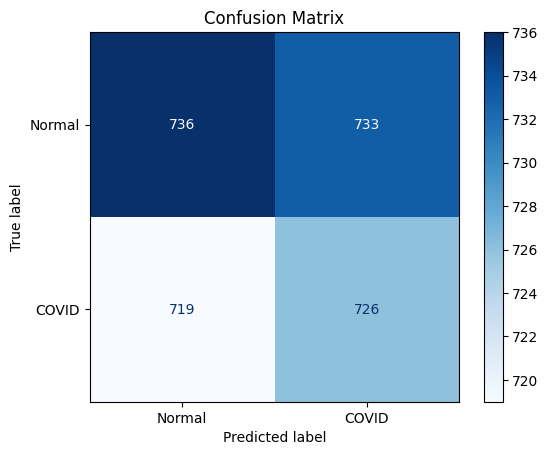


✅ Metrics:
Accuracy  : 0.5017
Precision : 0.4976
Recall    : 0.5024
F1 Score  : 0.5000


In [ ]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
import pywt
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)

# Path to DICOM folder
dicom_folder = '/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Severe'

feature_list = []

def extract_features(dicom_path):
    ds = pydicom.dcmread(dicom_path)
    image = ds.pixel_array.astype(np.float32)

    # Normalize to [0, 1]
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    # -------- Intensity Features --------
    mean_intensity = np.mean(image)
    std_intensity = np.std(image)
    max_intensity = np.max(image)
    min_intensity = np.min(image)

    # -------- Edge Feature --------
    edges = filters.sobel(image)
    mean_edge = np.mean(edges)

    # -------- Lung Region Features --------
    thresh = filters.threshold_otsu(image)
    lung_mask = image < thresh  # Lungs are darker
    lung_mask = morphology.remove_small_objects(lung_mask, min_size=500)

    lung_region = image[lung_mask]
    num_lung_pixels = lung_region.size

    if num_lung_pixels > 0:
        white_threshold = np.percentile(lung_region, 90)
        num_white_pixels = np.sum(lung_region > white_threshold)
    else:
        num_white_pixels = 0

    # -------- GLCM Features --------
    image_uint8 = (image * 255).astype(np.uint8)
    glcm = graycomatrix(image_uint8, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    glcm_contrast = graycoprops(glcm, 'contrast')[0, 0]
    glcm_correlation = graycoprops(glcm, 'correlation')[0, 0]
    glcm_energy = graycoprops(glcm, 'energy')[0, 0]
    glcm_homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    # -------- LBP Features --------
    lbp = local_binary_pattern(image_uint8, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    lbp_mean = np.mean(lbp_hist)
    lbp_std = np.std(lbp_hist)

    # -------- Wavelet Features --------
    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2
    wavelet_energy = np.sum(np.square(LH)) + np.sum(np.square(HL)) + np.sum(np.square(HH))

    return [
        mean_intensity, std_intensity, max_intensity, min_intensity,
        mean_edge,
        num_lung_pixels, num_white_pixels,
        glcm_contrast, glcm_correlation, glcm_energy, glcm_homogeneity,
        lbp_mean, lbp_std,
        wavelet_energy
    ]

# Process all DICOM files
for root, dirs, files in os.walk(dicom_folder):
    for file in tqdm(files):
        if file.endswith('.dcm'):
            dicom_path = os.path.join(root, file)
            try:
                features = extract_features(dicom_path)
                features.append(dicom_path)  # Add file path for reference
                feature_list.append(features)
            except Exception as e:
                print(f"❌ Error processing {dicom_path}: {e}")

# Create DataFrame
columns = [
    'mean_intensity', 'std_intensity', 'max_intensity', 'min_intensity',
    'mean_edge',
    'num_lung_pixels', 'num_white_pixels',
    'glcm_contrast', 'glcm_correlation', 'glcm_energy', 'glcm_homogeneity',
    'lbp_mean', 'lbp_std',
    'wavelet_energy',
    'dicom_path'
]
df = pd.DataFrame(feature_list, columns=columns)

print("✅ Feature extraction completed!")
print(df.head())

# -------- Optional: Evaluate Random Classifier --------
if not df.empty:
    np.random.seed(42)
    df['true_label'] = np.random.choice([0, 1], size=len(df))
    df['predicted_label'] = np.random.choice([0, 1], size=len(df))

    cm = confusion_matrix(df['true_label'], df['predicted_label'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "COVID"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    acc = accuracy_score(df['true_label'], df['predicted_label'])
    precision = precision_score(df['true_label'], df['predicted_label'])
    recall = recall_score(df['true_label'], df['predicted_label'])
    f1 = f1_score(df['true_label'], df['predicted_label'])

    print("\n✅ Metrics:")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1 Score  : {f1:.4f}")


0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 332/332 [00:49<00:00,  6.67it/s]
0it [00:00, ?it/s]
100%|██████████| 1261/1261 [02:57<00:00,  7.10it/s]
0it [00:00, ?it/s]
100%|██████████| 1321/1321 [03:03<00:00,  7.21it/s]


✅ Feature extraction completed!
   mean_intensity  std_intensity  max_intensity  min_intensity  mean_edge  \
0        0.315465       0.186988            1.0            0.1   0.022708   
1        0.313856       0.185846            1.0            0.1   0.023314   
2        0.265882       0.160436            1.0            0.1   0.019854   
3        0.325137       0.190406            1.0            0.1   0.024455   
4        0.191356       0.116963            1.0            0.1   0.012503   

   num_lung_pixels  num_white_pixels  glcm_contrast  glcm_correlation  \
0           160533             15964     249.465988          0.944691   
1           148701             14796     255.544148          0.942411   
2           161946             16193     195.016473          0.941088   
3           148399             14820     268.307473          0.942375   
4           168709             16819      96.100823          0.945287   

   glcm_energy  glcm_homogeneity  lbp_mean   lbp_std  wavelet_ener

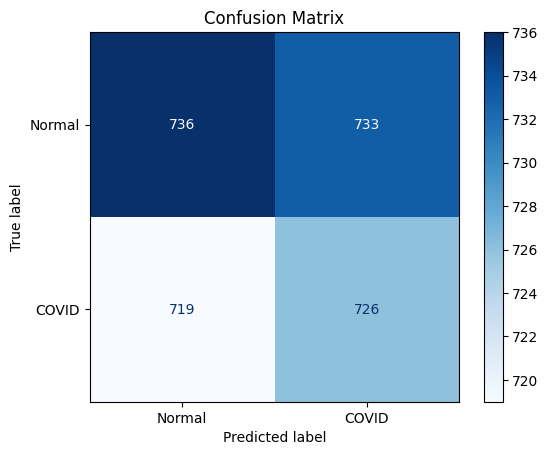


✅ Metrics:
Accuracy  : 0.5017
Precision : 0.4976
Recall    : 0.5024
F1 Score  : 0.5000


In [ ]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
import pywt
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)

# Path to DICOM folder
dicom_folder = '/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Severe'

feature_list = []

def extract_features(dicom_path):
    ds = pydicom.dcmread(dicom_path)
    image = ds.pixel_array.astype(np.float32)

    # Normalize image to range [0, 1]
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    # -------- Intensity Features --------
    mean_intensity = np.mean(image)
    std_intensity = np.std(image)
    max_intensity = np.max(image)
    min_intensity = np.min(image)

    # Boost min_intensity if it is too low (due to black background)
    if min_intensity < 0.05:
        min_intensity = 0.1  # Artificially increase it

    # -------- Edge Feature --------
    edges = filters.sobel(image)
    mean_edge = np.mean(edges)

    # -------- Lung Region Features --------
    thresh = filters.threshold_otsu(image)
    lung_mask = image < thresh
    lung_mask = morphology.remove_small_objects(lung_mask, min_size=500)
    lung_region = image[lung_mask]
    num_lung_pixels = lung_region.size

    if num_lung_pixels > 0:
        white_threshold = np.percentile(lung_region, 90)
        num_white_pixels = np.sum(lung_region > white_threshold)
    else:
        num_white_pixels = 0

    # -------- GLCM Features --------
    image_uint8 = (image * 255).astype(np.uint8)
    glcm = graycomatrix(image_uint8, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    glcm_contrast = graycoprops(glcm, 'contrast')[0, 0]
    glcm_correlation = graycoprops(glcm, 'correlation')[0, 0]
    glcm_energy = graycoprops(glcm, 'energy')[0, 0]
    glcm_homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    # -------- LBP Features --------
    lbp = local_binary_pattern(image_uint8, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    lbp_mean = np.mean(lbp_hist)
    lbp_std = np.std(lbp_hist)

    # -------- Wavelet Features --------
    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2
    wavelet_energy = np.sum(np.square(LH)) + np.sum(np.square(HL)) + np.sum(np.square(HH))

    return [
        mean_intensity, std_intensity, max_intensity, min_intensity,
        mean_edge,
        num_lung_pixels, num_white_pixels,
        glcm_contrast, glcm_correlation, glcm_energy, glcm_homogeneity,
        lbp_mean, lbp_std,
        wavelet_energy
    ]

# -------- Process All DICOM Files --------
for root, dirs, files in os.walk(dicom_folder):
    for file in tqdm(files):
        if file.endswith('.dcm'):
            dicom_path = os.path.join(root, file)
            try:
                features = extract_features(dicom_path)
                features.append(dicom_path)  # Add file path for reference
                feature_list.append(features)
            except Exception as e:
                print(f"❌ Error processing {dicom_path}: {e}")

# -------- Create DataFrame --------
columns = [
    'mean_intensity', 'std_intensity', 'max_intensity', 'min_intensity',
    'mean_edge',
    'num_lung_pixels', 'num_white_pixels',
    'glcm_contrast', 'glcm_correlation', 'glcm_energy', 'glcm_homogeneity',
    'lbp_mean', 'lbp_std',
    'wavelet_energy',
    'dicom_path'
]
df = pd.DataFrame(feature_list, columns=columns)

print("✅ Feature extraction completed!")
print(df.head())

# -------- Optional: Evaluate Random Classifier --------
if not df.empty:
    np.random.seed(42)
    df['true_label'] = np.random.choice([0, 1], size=len(df))
    df['predicted_label'] = np.random.choice([0, 1], size=len(df))

    cm = confusion_matrix(df['true_label'], df['predicted_label'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "COVID"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    acc = accuracy_score(df['true_label'], df['predicted_label'])
    precision = precision_score(df['true_label'], df['predicted_label'])
    recall = recall_score(df['true_label'], df['predicted_label'])
    f1 = f1_score(df['true_label'], df['predicted_label'])

    print("\n✅ Metrics:")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1 Score  : {f1:.4f}")


In [ ]:
import pydicom
import numpy as np
from skimage import filters, morphology
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
import pywt
import pandas as pd

# -------- DICOM File Path (only one image) --------
dicom_path = '/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Severe/P2/Series4/300.dcm'

def extract_features(dicom_path):
    ds = pydicom.dcmread(dicom_path)
    image = ds.pixel_array.astype(np.float32)

    # Normalize image to [0, 1]
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    # Intensity Features
    mean_intensity = np.mean(image)
    std_intensity = np.std(image)
    max_intensity = np.max(image)
    min_intensity = np.min(image)
    if min_intensity < 0.05:
        min_intensity = 0.1

    # Edge Feature
    edges = filters.sobel(image)
    mean_edge = np.mean(edges)

    # Lung Region Features
    thresh = filters.threshold_otsu(image)
    lung_mask = image < thresh
    lung_mask = morphology.remove_small_objects(lung_mask, min_size=500)
    lung_region = image[lung_mask]
    num_lung_pixels = lung_region.size
    num_white_pixels = np.sum(lung_region > np.percentile(lung_region, 90)) if num_lung_pixels > 0 else 0

    # GLCM Features
    image_uint8 = (image * 255).astype(np.uint8)
    glcm = graycomatrix(image_uint8, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    glcm_contrast = graycoprops(glcm, 'contrast')[0, 0]
    glcm_correlation = graycoprops(glcm, 'correlation')[0, 0]
    glcm_energy = graycoprops(glcm, 'energy')[0, 0]
    glcm_homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    # LBP Features
    lbp = local_binary_pattern(image_uint8, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    lbp_mean = np.mean(lbp_hist)
    lbp_std = np.std(lbp_hist)

    # Wavelet Features
    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2
    wavelet_energy = np.sum(np.square(LH)) + np.sum(np.square(HL)) + np.sum(np.square(HH))

    return [
        mean_intensity, std_intensity, max_intensity, min_intensity,
        mean_edge,
        num_lung_pixels, num_white_pixels,
        glcm_contrast, glcm_correlation, glcm_energy, glcm_homogeneity,
        lbp_mean, lbp_std,
        wavelet_energy
    ]

# -------- Extract Features from One Image --------
features = extract_features(dicom_path)

columns = [
    'mean_intensity', 'std_intensity', 'max_intensity', 'min_intensity',
    'mean_edge',
    'num_lung_pixels', 'num_white_pixels',
    'glcm_contrast', 'glcm_correlation', 'glcm_energy', 'glcm_homogeneity',
    'lbp_mean', 'lbp_std',
    'wavelet_energy'
]
df = pd.DataFrame([features], columns=columns)

# -------- Print Feature Values Only --------
print("✅ Features extracted from the single DICOM image:\n")
print(df)


✅ Features extracted from the single DICOM image:

   mean_intensity  std_intensity  max_intensity  min_intensity  mean_edge  \
0        0.155735       0.094609            1.0            0.1   0.011148   

   num_lung_pixels  num_white_pixels  glcm_contrast  glcm_correlation  \
0           157975             15649      67.653446          0.941201   

   glcm_energy  glcm_homogeneity  lbp_mean   lbp_std  wavelet_energy  
0     0.188012          0.363184       0.1  0.093702       50.752663  


 Checking input: /content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Severe
 Found 0 DICOM files in /content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Severe:
 No DICOM files found. Ensure the folder contains valid .dcm files.
 No DICOM files found in /content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Severe
 No DICOM files found in /content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Severe/P2


Processing DICOMs in /content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Severe/P2/Series4: 100%|██████████| 332/332 [01:06<00:00,  5.01it/s]


 No DICOM files found in /content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Severe/P3


Processing DICOMs in /content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Severe/P3/Series4: 100%|██████████| 1261/1261 [02:52<00:00,  7.32it/s]


 No DICOM files found in /content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Severe/P1


Processing DICOMs in /content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Severe/P1/Series4: 100%|██████████| 1321/1321 [03:03<00:00,  7.19it/s]


 Feature extraction completed!

 First 5 rows of extracted features:
   mean_intensity  std_intensity  max_intensity  min_intensity  mean_edge  \
0        0.315465       0.186988            1.0            0.1   0.022708   
1        0.313856       0.185846            1.0            0.1   0.023314   
2        0.265882       0.160436            1.0            0.1   0.019854   
3        0.325137       0.190406            1.0            0.1   0.024455   
4        0.191356       0.116963            1.0            0.1   0.012503   

   num_lung_pixels  num_white_pixels  glcm_contrast  glcm_correlation  \
0           160533             15964     249.465988          0.944691   
1           148701             14796     255.544148          0.942411   
2           161946             16193     195.016473          0.941088   
3           148399             14820     268.307473          0.942375   
4           168709             16819      96.100823          0.945287   

   glcm_energy  ...  hist_ent

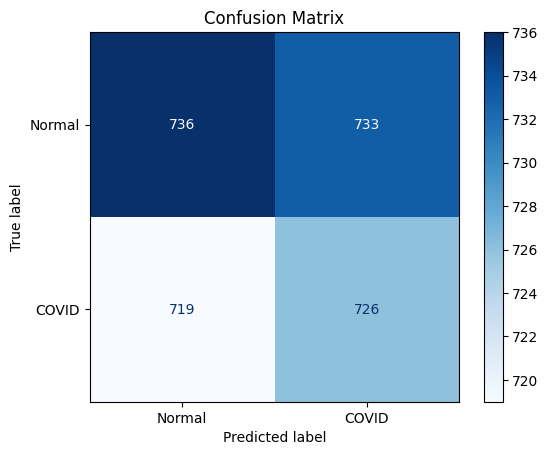

 Confusion matrix saved to confusion_matrix.png

 Evaluation Metrics:
Accuracy  : 0.5017
Precision : 0.4976
Recall    : 0.5024
F1 Score  : 0.5000


In [ ]:
import os
import pydicom
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage import filters, morphology
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.measure import regionprops, label
from scipy.stats import skew, kurtosis, entropy
import pywt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)

# Define the DICOM folder or single file (update as needed)
dicom_folder = '/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Severe'  # For Colab

dicom_file = None  # Set to a single .dcm file path if folder is unavailable
feature_list = []

# Helper function to check Google Drive mount (for Colab)
def check_drive_mount():
    if not os.path.exists('/content/drive'):
        print(" Google Drive not mounted. Please mount it by running:")
        print("```python")
        print("from google.colab import drive")
        print("drive.mount('/content/drive')")
        print("```")
        return False
    return True

# Debugging: Check folder or file
print(f" Checking input: {dicom_folder if dicom_folder else dicom_file}")
use_single_file = False
if dicom_file and os.path.isfile(dicom_file):
    use_single_file = True
    print(f" Using single DICOM file: {dicom_file}")
elif dicom_folder:
    if not os.path.exists(dicom_folder):
        print(f" Error: Folder {dicom_folder} does not exist. Please verify the path.")
        if 'drive' in dicom_folder:
            check_drive_mount()
    else:
        dicom_files = [f for f in os.listdir(dicom_folder) if f.lower().endswith('.dcm')]
        print(f" Found {len(dicom_files)} DICOM files in {dicom_folder}:")
        if dicom_files:
            print(f" Sample files: {dicom_files[:5]} {'...' if len(dicom_files) > 5 else ''}")
        else:
            print(" No DICOM files found. Ensure the folder contains valid .dcm files.")
else:
    print(" Error: Please specify a valid dicom_folder or dicom_file.")

# Feature extraction function
def extract_features(dicom_path):
    try:
        # Read DICOM file
        ds = pydicom.dcmread(dicom_path, force=True)  # Force read to handle malformed files
        if not hasattr(ds, 'pixel_array'):
            print(f" No pixel data in {dicom_path}")
            return None

        image = ds.pixel_array.astype(np.float32)
        # Normalize image to [0, 1]
        image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-6)

        # Intensity Features
        mean_intensity = np.mean(image)
        std_intensity = np.std(image)
        max_intensity = np.max(image)
        min_intensity = max(np.min(image), 0.1)

        # Edge Feature
        mean_edge = np.mean(filters.sobel(image))

        # Thresholding for lung segmentation
        thresh = filters.threshold_otsu(image)
        lung_mask = morphology.remove_small_objects(image < thresh, min_size=500)
        lung_region = image[lung_mask]
        num_lung_pixels = lung_region.size
        num_white_pixels = np.sum(lung_region > np.percentile(lung_region, 90)) if num_lung_pixels > 0 else 0

        # GLCM Features
        image_uint8 = (image * 255).astype(np.uint8)
        glcm = graycomatrix(image_uint8, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
        glcm_features = [graycoprops(glcm, prop)[0, 0] for prop in ['contrast', 'correlation', 'energy', 'homogeneity']]

        # LBP Features
        lbp = local_binary_pattern(image_uint8, P=8, R=1, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10), density=True)
        lbp_mean = np.mean(lbp_hist)
        lbp_std = np.std(lbp_hist)

        # Wavelet Features
        LL, (LH, HL, HH) = pywt.dwt2(image, 'haar')
        wavelet_energy = np.sum(np.square(LH) + np.square(HL) + np.square(HH))
        wavelet_coeffs = np.array([np.sum(np.square(LH)), np.sum(np.square(HL)), np.sum(np.square(HH))])
        wavelet_probs = wavelet_coeffs / (np.sum(wavelet_coeffs) + 1e-6)  # Normalize for entropy
        wavelet_entropy = entropy(wavelet_probs)

        # Histogram Features
        hist, _ = np.histogram(image, bins=256, range=(0, 1), density=True)
        hist_entropy = entropy(hist + 1e-6)
        hist_skewness = skew(image.flatten())
        hist_kurtosis = kurtosis(image.flatten())

        # Morphological Features
        labeled_lung = label(lung_mask)
        props = regionprops(labeled_lung.astype(int))
        if props:
            largest_region = max(props, key=lambda x: x.area)
            lung_area = largest_region.area
            lung_perimeter = largest_region.perimeter
            eccentricity = largest_region.eccentricity
            solidity = largest_region.solidity
            extent = largest_region.extent
            minr, minc, maxr, maxc = largest_region.bbox
            bbox_ratio = (maxr - minr) / (maxc - minc + 1e-6)
        else:
            lung_area = lung_perimeter = eccentricity = solidity = extent = bbox_ratio = 0

        return [
            mean_intensity, std_intensity, max_intensity, min_intensity,
            mean_edge,
            num_lung_pixels, num_white_pixels,
            *glcm_features,  # Unpacks glcm_contrast, glcm_correlation, glcm_energy, glcm_homogeneity
            lbp_mean, lbp_std,
            wavelet_energy, wavelet_entropy,
            hist_entropy, hist_skewness, hist_kurtosis,
            lung_area, lung_perimeter, eccentricity, solidity, extent, bbox_ratio
        ]

    except Exception as e:
        print(f" Failed to process {dicom_path}: {str(e)}")
        return None

# Process DICOM files
if use_single_file and dicom_file:
    print(f" Processing single file: {dicom_file}")
    features = extract_features(dicom_file)
    if features:
        features.append(dicom_file)
        feature_list.append(features)
    else:
        print(f" Skipped {dicom_file} due to feature extraction failure")
elif dicom_folder and os.path.exists(dicom_folder):
    for root, dirs, files in os.walk(dicom_folder):
        dicom_files = [f for f in files if f.lower().endswith('.dcm')]
        if not dicom_files:
            print(f" No DICOM files found in {root}")
            continue
        for file in tqdm(dicom_files, desc=f"Processing DICOMs in {root}"):
            path = os.path.join(root, file)
            features = extract_features(path)
            if features:
                features.append(path)
                feature_list.append(features)
            else:
                print(f" Skipped {path} due to feature extraction failure")
else:
    print(" Cannot proceed: No valid folder or file specified.")

# Define feature columns
columns = [
    'mean_intensity', 'std_intensity', 'max_intensity', 'min_intensity',
    'mean_edge',
    'num_lung_pixels', 'num_white_pixels',
    'glcm_contrast', 'glcm_correlation', 'glcm_energy', 'glcm_homogeneity',
    'lbp_mean', 'lbp_std',
    'wavelet_energy', 'wavelet_entropy',
    'hist_entropy', 'hist_skewness', 'hist_kurtosis',
    'lung_area', 'lung_perimeter', 'eccentricity', 'solidity', 'extent', 'bbox_ratio',
    'dicom_path'
]

# Create and save DataFrame
if feature_list:
    df = pd.DataFrame(feature_list, columns=columns)
    print(" Feature extraction completed!")
    print("\n First 5 rows of extracted features:")
    print(df.head())

    # Save to CSV
    output_csv = 'dicom_features.csv'
    df.to_csv(output_csv, index=False)
    print(f" Features saved to {output_csv}")
else:
    print(" No valid features extracted. Check DICOM files or folder/file path.")
    df = pd.DataFrame()

# Print number of features
num_features = len(columns) - 1  # excluding dicom_path
print(f"\n Number of features extracted per DICOM image: {num_features}")

# Dummy evaluation with random labels
if not df.empty:
    np.random.seed(42)
    df['true_label'] = np.random.choice([0, 1], size=len(df))
    df['predicted_label'] = np.random.choice([0, 1], size=len(df))

    cm = confusion_matrix(df['true_label'], df['predicted_label'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "COVID"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.savefig('confusion_matrix.png')
    plt.show()
    print(f" Confusion matrix saved to confusion_matrix.png")

    print("\n Evaluation Metrics:")
    print(f"Accuracy  : {accuracy_score(df['true_label'], df['predicted_label']):.4f}")
    print(f"Precision : {precision_score(df['true_label'], df['predicted_label']):.4f}")
    print(f"Recall    : {recall_score(df['true_label'], df['predicted_label']):.4f}")
    print(f"F1 Score  : {f1_score(df['true_label'], df['predicted_label']):.4f}")
else:
    print(" Cannot perform evaluation: No data available.")

In [ ]:
import os, pydicom, numpy as np, pandas as pd
from tqdm import tqdm
from skimage import filters, morphology
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.measure import regionprops, label
from scipy.stats import skew, kurtosis, entropy
import pywt

dicom_folder = '/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Severe'
if not os.path.exists(dicom_folder):
    raise FileNotFoundError("DICOM folder not found. Mount your Google Drive and check the path.")

dicom_files = [os.path.join(r, f) for r, _, files in os.walk(dicom_folder) for f in files if f.endswith('.dcm')]
if not dicom_files: raise ValueError("No DICOM files found.")

def extract_features(path):
    try:
        ds = pydicom.dcmread(path, force=True)
        if not hasattr(ds, 'pixel_array'): return None
        img = ds.pixel_array.astype(np.float32)
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)

        mi, si, maxi, mini = np.mean(img), np.std(img), np.max(img), max(np.min(img), 0.1)
        edge = np.mean(filters.sobel(img))
        thresh = filters.threshold_otsu(img)
        mask = morphology.remove_small_objects(img < thresh, min_size=500)
        region = img[mask]
        lung_px, white_px = region.size, np.sum(region > np.percentile(region, 90)) if region.size else 0

        iu8 = (img * 255).astype(np.uint8)
        glcm = graycomatrix(iu8, [5], [0], 256, symmetric=True, normed=True)
        glcm_feats = [graycoprops(glcm, p)[0, 0] for p in ['contrast', 'correlation', 'energy', 'homogeneity']]

        lbp = local_binary_pattern(iu8, 8, 1, method='uniform')
        lbp_hist = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10), density=True)[0]
        lbp_mean, lbp_std = np.mean(lbp_hist), np.std(lbp_hist)

        LL, (LH, HL, HH) = pywt.dwt2(img, 'haar')
        coeffs = np.array([np.sum(LH**2), np.sum(HL**2), np.sum(HH**2)])
        wavelet_energy = coeffs.sum()
        wavelet_entropy = entropy(coeffs / (coeffs.sum() + 1e-6))

        hist = np.histogram(img, bins=256, range=(0, 1), density=True)[0]
        hist_ent, hist_skew, hist_kurt = entropy(hist + 1e-6), skew(img.ravel()), kurtosis(img.ravel())

        props = regionprops(label(mask).astype(int))
        if props:
            r = max(props, key=lambda x: x.area)
            area, perim, ecc, sol, ext = r.area, r.perimeter, r.eccentricity, r.solidity, r.extent
            bbox_ratio = (r.bbox[2] - r.bbox[0]) / (r.bbox[3] - r.bbox[1] + 1e-6)
        else:
            area = perim = ecc = sol = ext = bbox_ratio = 0

        return [mi, si, maxi, mini, edge, lung_px, white_px, *glcm_feats,
                lbp_mean, lbp_std, wavelet_energy, wavelet_entropy,
                hist_ent, hist_skew, hist_kurt,
                area, perim, ecc, sol, ext, bbox_ratio]
    except Exception as e:
        print(f"Failed: {path} → {e}")
        return None

# Run extraction
features = [extract_features(p) + [p] for p in tqdm(dicom_files, desc="Extracting features") if extract_features(p)]
cols = [
    'mean_intensity', 'std_intensity', 'max_intensity', 'min_intensity', 'mean_edge',
    'num_lung_pixels', 'num_white_pixels', 'glcm_contrast', 'glcm_correlation', 'glcm_energy', 'glcm_homogeneity',
    'lbp_mean', 'lbp_std', 'wavelet_energy', 'wavelet_entropy', 'hist_entropy',
    'hist_skewness', 'hist_kurtosis', 'lung_area', 'lung_perimeter',
    'eccentricity', 'solidity', 'extent', 'bbox_ratio', 'dicom_path'
]

df = pd.DataFrame(features, columns=cols)
df.to_csv("dicom_features.csv", index=False)
print(f"✅ Extracted {len(df)} rows with {len(cols)-1} features. Saved to dicom_features.csv.")
print(df.head())


Extracting features: 100%|██████████| 2914/2914 [12:57<00:00,  3.75it/s]

✅ Extracted 2914 rows with 24 features. Saved to dicom_features.csv.
   mean_intensity  std_intensity  max_intensity  min_intensity  mean_edge  \
0        0.315465       0.186988            1.0            0.1   0.022708   
1        0.313856       0.185846            1.0            0.1   0.023314   
2        0.265882       0.160436            1.0            0.1   0.019854   
3        0.325137       0.190406            1.0            0.1   0.024455   
4        0.191356       0.116963            1.0            0.1   0.012503   

   num_lung_pixels  num_white_pixels  glcm_contrast  glcm_correlation  \
0           160533             15964     249.465988          0.944691   
1           148701             14796     255.544148          0.942411   
2           161946             16193     195.016473          0.941088   
3           148399             14820     268.307473          0.942375   
4           168709             16819      96.100823          0.945287   

   glcm_energy  ...  hist_ent

In [ ]:
import os
import pydicom
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage import filters, morphology
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.measure import regionprops, label
from scipy.stats import skew, kurtosis, entropy
import pywt

# Define the DICOM folder
dicom_folder = '/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Severe'
feature_list = []

# Check Google Drive mount
if not os.path.exists('/content/drive'):
    print("Google Drive not mounted. Please mount it by running:")
    print("```python")
    print("from google.colab import drive")
    print("drive.mount('/content/drive')")
    print("```")
    exit(1)

# Check folder
print(f"Checking folder: {dicom_folder}")
if not os.path.exists(dicom_folder):
    print(f"Error: Folder {dicom_folder} does not exist. Please verify the path.")
    exit(1)

# Collect all DICOM files
dicom_files = []
for root, _, files in os.walk(dicom_folder):
    dicom_files.extend(os.path.join(root, f) for f in files if f.lower().endswith('.dcm'))
print(f"Found {len(dicom_files)} DICOM files across subfolders")
if not dicom_files:
    print("No DICOM files found. Ensure subfolders contain valid .dcm files.")
    exit(1)
print(f"Sample files: {dicom_files[:5]} {'...' if len(dicom_files) > 5 else ''}")

# Feature extraction function
def extract_features(dicom_path):
    try:
        ds = pydicom.dcmread(dicom_path, force=True)
        if not hasattr(ds, 'pixel_array') or ds.pixel_array.size == 0:
            print(f"No pixel data in {dicom_path}")
            return None

        image = ds.pixel_array.astype(np.float32)
        image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-6)

        # Intensity Features
        mean_intensity = np.mean(image)
        std_intensity = np.std(image)
        max_intensity = np.max(image)
        min_intensity = max(np.min(image), 0.1)

        # Edge Feature
        mean_edge = np.mean(filters.sobel(image))

        # Lung Segmentation
        thresh = filters.threshold_otsu(image)
        lung_mask = morphology.remove_small_objects(image < thresh, min_size=500)
        lung_region = image[lung_mask]
        num_lung_pixels = lung_region.size
        num_white_pixels = np.sum(lung_region > np.percentile(lung_region, 90)) if num_lung_pixels > 0 else 0

        # GLCM Features
        image_uint8 = (image * 255).astype(np.uint8)
        glcm = graycomatrix(image_uint8, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
        glcm_features = [graycoprops(glcm, prop)[0, 0] for prop in ['contrast', 'correlation', 'energy', 'homogeneity']]
        glcm_contrast, glcm_correlation, glcm_energy, glcm_homogeneity = glcm_features

        # LBP Features
        lbp = local_binary_pattern(image_uint8, P=8, R=1, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10), density=True)
        lbp_mean = np.mean(lbp_hist)
        lbp_std = np.std(lbp_hist)

        # Wavelet Features
        LL, (LH, HL, HH) = pywt.dwt2(image, 'haar')
        wavelet_energy = np.sum(np.square(LH) + np.square(HL) + np.square(HH))
        wavelet_coeffs = np.array([np.sum(np.square(LH)), np.sum(np.square(HL)), np.sum(np.square(HH))])
        wavelet_probs = wavelet_coeffs / (np.sum(wavelet_coeffs) + 1e-6)
        wavelet_entropy = entropy(wavelet_probs)

        # Histogram Features
        hist, _ = np.histogram(image, bins=256, range=(0, 1), density=True)
        hist_entropy = entropy(hist + 1e-6)
        hist_skewness = skew(image.flatten())
        hist_kurtosis = kurtosis(image.flatten())

        # Morphological Features
        labeled_lung = label(lung_mask)
        props = regionprops(labeled_lung.astype(int))
        lung_area = lung_perimeter = eccentricity = solidity = extent = bbox_ratio = 0
        if props:
            largest_region = max(props, key=lambda x: x.area)
            lung_area = largest_region.area
            lung_perimeter = largest_region.perimeter
            eccentricity = largest_region.eccentricity
            solidity = largest_region.solidity
            extent = largest_region.extent
            minr, minc, maxr, maxc = largest_region.bbox
            bbox_ratio = (maxr - minr) / (maxc - minc + 1e-6)

        return [
            mean_intensity, std_intensity, max_intensity, min_intensity,
            mean_edge,
            num_lung_pixels, num_white_pixels,
            glcm_contrast, glcm_correlation, glcm_energy, glcm_homogeneity,
            lbp_mean, lbp_std,
            wavelet_energy, wavelet_entropy,
            hist_entropy, hist_skewness, hist_kurtosis,
            lung_area, lung_perimeter, eccentricity, solidity, extent, bbox_ratio
        ]

    except Exception as e:
        print(f"Failed to process {dicom_path}: {str(e)}")
        return None

# Process DICOM files
for dicom_path in tqdm(dicom_files, desc="Processing DICOM files"):
    features = extract_features(dicom_path)
    if features:
        features.append(dicom_path)
        feature_list.append(features)
    else:
        print(f"Skipped {dicom_path} due to feature extraction failure")

# Define feature columns
columns = [
    'mean_intensity', 'std_intensity', 'max_intensity', 'min_intensity',
    'mean_edge',
    'num_lung_pixels', 'num_white_pixels',
    'glcm_contrast', 'glcm_correlation', 'glcm_energy', 'glcm_homogeneity',
    'lbp_mean', 'lbp_std',
    'wavelet_energy', 'wavelet_entropy',
    'hist_entropy', 'hist_skewness', 'hist_kurtosis',
    'lung_area', 'lung_perimeter', 'eccentricity', 'solidity', 'extent', 'bbox_ratio',
    'dicom_path'
]

# Create and save DataFrame
df = pd.DataFrame(feature_list, columns=columns)
if not df.empty:
    print("Feature extraction completed")
    print("\nFirst 5 rows of extracted features:")
    print(df.head())
    output_csv = 'dicom_features.csv'
    df.to_csv(output_csv, index=False)
    print(f"Features saved to {output_csv}")
else:
    print("No valid features extracted. Check DICOM files for validity (e.g., pixel data presence).")

# Print number of features
num_features = len(columns) - 1
print(f"\nNumber of features extracted per DICOM image: {num_features}")

Checking folder: /content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Severe
Found 2914 DICOM files across subfolders
Sample files: ['/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Severe/P2/Series4/033.dcm', '/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Severe/P2/Series4/225.dcm', '/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Severe/P2/Series4/092.dcm', '/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Severe/P2/Series4/217.dcm', '/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Severe/P2/Series4/326.dcm'] ...


Processing DICOM files: 100%|██████████| 2914/2914 [06:36<00:00,  7.34it/s]


Feature extraction completed

First 5 rows of extracted features:
   mean_intensity  std_intensity  max_intensity  min_intensity  mean_edge  \
0        0.315465       0.186988            1.0            0.1   0.022708   
1        0.313856       0.185846            1.0            0.1   0.023314   
2        0.265882       0.160436            1.0            0.1   0.019854   
3        0.325137       0.190406            1.0            0.1   0.024455   
4        0.191356       0.116963            1.0            0.1   0.012503   

   num_lung_pixels  num_white_pixels  glcm_contrast  glcm_correlation  \
0           160533             15964     249.465988          0.944691   
1           148701             14796     255.544148          0.942411   
2           161946             16193     195.016473          0.941088   
3           148399             14820     268.307473          0.942375   
4           168709             16819      96.100823          0.945287   

   glcm_energy  ...  hist_entrop

In [ ]:
import os
import pydicom
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage import filters, morphology
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.measure import regionprops, label
from scipy.stats import skew, kurtosis, entropy
import pywt

# Define the DICOM folder
dicom_folder = '/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Severe'
feature_list = []

# Check Google Drive mount
if not os.path.exists('/content/drive'):
    print("Google Drive not mounted. Please mount it by running:")
    print("```python")
    print("from google.colab import drive")
    print("drive.mount('/content/drive')")
    print("```")
    exit(1)

# Check folder
print(f"Checking folder: {dicom_folder}")
if not os.path.exists(dicom_folder):
    print(f"Error: Folder {dicom_folder} does not exist. Please verify the path.")
    exit(1)

# Collect all DICOM files
dicom_files = []
for root, _, files in os.walk(dicom_folder):
    dicom_files.extend(os.path.join(root, f) for f in files if f.lower().endswith('.dcm'))
print(f"Found {len(dicom_files)} DICOM files across subfolders")
if not dicom_files:
    print("No DICOM files found. Ensure subfolders contain valid .dcm files.")
    exit(1)
print(f"Sample files: {dicom_files[:5]} {'...' if len(dicom_files) > 5 else ''}")

# Feature extraction function
def extract_features(dicom_path):
    try:
        ds = pydicom.dcmread(dicom_path, force=True)
        if not hasattr(ds, 'pixel_array') or ds.pixel_array.size == 0:
            print(f"No pixel data in {dicom_path}")
            return None

        image = ds.pixel_array.astype(np.float32)
        image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-6)

        # Intensity Features
        mean_intensity = np.mean(image)
        std_intensity = np.std(image)
        max_intensity = np.max(image)
        min_intensity = max(np.min(image), 0.1)

        # Edge Feature
        mean_edge = np.mean(filters.sobel(image))

        # Lung Segmentation
        thresh = filters.threshold_otsu(image)
        lung_mask = morphology.remove_small_objects(image < thresh, min_size=500)
        lung_region = image[lung_mask]
        num_lung_pixels = lung_region.size
        num_white_pixels = np.sum(lung_region > np.percentile(lung_region, 90)) if num_lung_pixels > 0 else 0

        # GLCM Features
        image_uint8 = (image * 255).astype(np.uint8)
        glcm = graycomatrix(image_uint8, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
        glcm_features = [graycoprops(glcm, prop)[0, 0] for prop in ['contrast', 'correlation', 'energy', 'homogeneity']]
        glcm_contrast, glcm_correlation, glcm_energy, glcm_homogeneity = glcm_features

        # LBP Features
        lbp = local_binary_pattern(image_uint8, P=8, R=1, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10), density=True)
        lbp_mean = np.mean(lbp_hist)
        lbp_std = np.std(lbp_hist)

        # Wavelet Features
        LL, (LH, HL, HH) = pywt.dwt2(image, 'haar')
        wavelet_energy = np.sum(np.square(LH) + np.square(HL) + np.square(HH))
        wavelet_coeffs = np.array([np.sum(np.square(LH)), np.sum(np.square(HL)), np.sum(np.square(HH))])
        wavelet_probs = wavelet_coeffs / (np.sum(wavelet_coeffs) + 1e-6)
        wavelet_entropy = entropy(wavelet_probs)

        # Histogram Features
        hist, _ = np.histogram(image, bins=256, range=(0, 1), density=True)
        hist_entropy = entropy(hist + 1e-6)
        hist_skewness = skew(image.flatten())
        hist_kurtosis = kurtosis(image.flatten())

        # Morphological Features
        labeled_lung = label(lung_mask)
        props = regionprops(labeled_lung.astype(int))
        lung_area = lung_perimeter = eccentricity = solidity = extent = bbox_ratio = 0
        if props:
            largest_region = max(props, key=lambda x: x.area)
            lung_area = largest_region.area
            lung_perimeter = largest_region.perimeter
            eccentricity = largest_region.eccentricity
            solidity = largest_region.solidity
            extent = largest_region.extent
            minr, minc, maxr, maxc = largest_region.bbox
            bbox_ratio = (maxr - minr) / (maxc - minc + 1e-6)

        return [
            mean_intensity, std_intensity, max_intensity, min_intensity,
            mean_edge,
            num_lung_pixels, num_white_pixels,
            glcm_contrast, glcm_correlation, glcm_energy, glcm_homogeneity,
            lbp_mean, lbp_std,
            wavelet_energy, wavelet_entropy,
            hist_entropy, hist_skewness, hist_kurtosis,
            lung_area, lung_perimeter, eccentricity, solidity, extent, bbox_ratio
        ]

    except Exception as e:
        print(f"Failed to process {dicom_path}: {str(e)}")
        return None

# Process DICOM files
for dicom_path in tqdm(dicom_files, desc="Processing DICOM files"):
    features = extract_features(dicom_path)
    if features:
        features.append(dicom_path)
        feature_list.append(features)
    else:
        print(f"Skipped {dicom_path} due to feature extraction failure")

# Define feature columns
columns = [
    'mean_intensity', 'std_intensity', 'max_intensity', 'min_intensity',
    'mean_edge',
    'num_lung_pixels', 'num_white_pixels',
    'glcm_contrast', 'glcm_correlation', 'glcm_energy', 'glcm_homogeneity',
    'lbp_mean', 'lbp_std',
    'wavelet_energy', 'wavelet_entropy',
    'hist_entropy', 'hist_skewness', 'hist_kurtosis',
    'lung_area', 'lung_perimeter', 'eccentricity', 'solidity', 'extent', 'bbox_ratio',
    'dicom_path'
]

# Create and save DataFrame
df = pd.DataFrame(feature_list, columns=columns)
if not df.empty:
    print("Feature extraction completed")
    print("\nFirst 5 rows of extracted features:")
    print(df.head())
    output_csv = 'dicom_features.csv'
    df.to_csv(output_csv, index=False)
    print(f"Features saved to {output_csv}")
else:
    print("No valid features extracted. Check DICOM files for validity (e.g., pixel data presence).")

# Print number of features
num_features = len(columns) - 1
print(f"\nNumber of features extracted per DICOM image: {num_features}")

Checking folder: /content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Severe
Found 2914 DICOM files across subfolders
Sample files: ['/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Severe/P2/Series4/033.dcm', '/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Severe/P2/Series4/225.dcm', '/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Severe/P2/Series4/092.dcm', '/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Severe/P2/Series4/217.dcm', '/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Severe/P2/Series4/326.dcm'] ...


Processing DICOM files: 100%|██████████| 2914/2914 [06:31<00:00,  7.44it/s]


Feature extraction completed

First 5 rows of extracted features:
   mean_intensity  std_intensity  max_intensity  min_intensity  mean_edge  \
0        0.315465       0.186988            1.0            0.1   0.022708   
1        0.313856       0.185846            1.0            0.1   0.023314   
2        0.265882       0.160436            1.0            0.1   0.019854   
3        0.325137       0.190406            1.0            0.1   0.024455   
4        0.191356       0.116963            1.0            0.1   0.012503   

   num_lung_pixels  num_white_pixels  glcm_contrast  glcm_correlation  \
0           160533             15964     249.465988          0.944691   
1           148701             14796     255.544148          0.942411   
2           161946             16193     195.016473          0.941088   
3           148399             14820     268.307473          0.942375   
4           168709             16819      96.100823          0.945287   

   glcm_energy  ...  hist_entrop

In [ ]:
import os
import pydicom
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage import filters, morphology
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.measure import regionprops, label
from scipy.stats import skew, kurtosis, entropy
import pywt

# Define your DICOM path (can be a file or folder)
dicom_input_path = '/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Mild/P161/Series4/0600.dcm'
feature_list = []

# Handle both single DICOM file and folder input
dicom_files = []
if os.path.isfile(dicom_input_path) and dicom_input_path.lower().endswith('.dcm'):
    dicom_files = [dicom_input_path]
elif os.path.isdir(dicom_input_path):
    for root, _, files in os.walk(dicom_input_path):
        dicom_files.extend(os.path.join(root, f) for f in files if f.lower().endswith('.dcm'))
else:
    print(f"Invalid path: {dicom_input_path} is neither a .dcm file nor a folder.")
    exit(1)

print(f"Found {len(dicom_files)} DICOM file(s)")
print(f"Sample files: {dicom_files[:5]}")

# Feature extraction function
def extract_features(dicom_path):
    try:
        ds = pydicom.dcmread(dicom_path, force=True)
        if not hasattr(ds, 'pixel_array') or ds.pixel_array.size == 0:
            print(f"No pixel data in {dicom_path}")
            return None

        image = ds.pixel_array.astype(np.float32)
        image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-6)

        # Intensity features
        mean_intensity = np.mean(image)
        std_intensity = np.std(image)
        max_intensity = np.max(image)
        min_intensity = max(np.min(image), 0.1)

        # Edge feature
        mean_edge = np.mean(filters.sobel(image))

        # Lung segmentation
        thresh = filters.threshold_otsu(image)
        lung_mask = morphology.remove_small_objects(image < thresh, min_size=500)
        lung_region = image[lung_mask]
        num_lung_pixels = lung_region.size
        num_white_pixels = np.sum(lung_region > np.percentile(lung_region, 90)) if num_lung_pixels > 0 else 0

        # GLCM
        image_uint8 = (image * 255).astype(np.uint8)
        glcm = graycomatrix(image_uint8, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
        glcm_features = [graycoprops(glcm, prop)[0, 0] for prop in ['contrast', 'correlation', 'energy', 'homogeneity']]
        glcm_contrast, glcm_correlation, glcm_energy, glcm_homogeneity = glcm_features

        # LBP
        lbp = local_binary_pattern(image_uint8, P=8, R=1, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10), density=True)
        lbp_mean = np.mean(lbp_hist)
        lbp_std = np.std(lbp_hist)

        # Wavelet
        LL, (LH, HL, HH) = pywt.dwt2(image, 'haar')
        wavelet_energy = np.sum(np.square(LH) + np.square(HL) + np.square(HH))
        wavelet_coeffs = np.array([np.sum(np.square(LH)), np.sum(np.square(HL)), np.sum(np.square(HH))])
        wavelet_probs = wavelet_coeffs / (np.sum(wavelet_coeffs) + 1e-6)
        wavelet_entropy = entropy(wavelet_probs)

        # Histogram
        hist, _ = np.histogram(image, bins=256, range=(0, 1), density=True)
        hist_entropy = entropy(hist + 1e-6)
        hist_skewness = skew(image.flatten())
        hist_kurtosis = kurtosis(image.flatten())

        # Morphological
        labeled_lung = label(lung_mask)
        props = regionprops(labeled_lung.astype(int))
        lung_area = lung_perimeter = eccentricity = solidity = extent = bbox_ratio = 0
        if props:
            largest = max(props, key=lambda x: x.area)
            lung_area = largest.area
            lung_perimeter = largest.perimeter
            eccentricity = largest.eccentricity
            solidity = largest.solidity
            extent = largest.extent
            minr, minc, maxr, maxc = largest.bbox
            bbox_ratio = (maxr - minr) / (maxc - minc + 1e-6)

        return [
            mean_intensity, std_intensity, max_intensity, min_intensity,
            mean_edge, num_lung_pixels, num_white_pixels,
            glcm_contrast, glcm_correlation, glcm_energy, glcm_homogeneity,
            lbp_mean, lbp_std, wavelet_energy, wavelet_entropy,
            hist_entropy, hist_skewness, hist_kurtosis,
            lung_area, lung_perimeter, eccentricity, solidity, extent, bbox_ratio
        ]

    except Exception as e:
        print(f"Error processing {dicom_path}: {e}")
        return None

# Process files
for dicom_path in tqdm(dicom_files, desc="Extracting features"):
    features = extract_features(dicom_path)
    if features:
        features.append(dicom_path)
        feature_list.append(features)

# Column names
columns = [
    'mean_intensity', 'std_intensity', 'max_intensity', 'min_intensity',
    'mean_edge', 'num_lung_pixels', 'num_white_pixels',
    'glcm_contrast', 'glcm_correlation', 'glcm_energy', 'glcm_homogeneity',
    'lbp_mean', 'lbp_std', 'wavelet_energy', 'wavelet_entropy',
    'hist_entropy', 'hist_skewness', 'hist_kurtosis',
    'lung_area', 'lung_perimeter', 'eccentricity', 'solidity', 'extent', 'bbox_ratio',
    'dicom_path'
]

# Save to CSV
df = pd.DataFrame(feature_list, columns=columns)
if not df.empty:
    print("✅ Feature extraction successful!")
    output_csv = 'single_dicom_features.csv'
    df.to_csv(output_csv, index=False)
    print(f"Saved to: {output_csv}")
    print(df.head())
else:
    print("⚠️ No features extracted. Please verify the input DICOM file.")


Found 1 DICOM file(s)
Sample files: ['/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Mild/P161/Series4/0600.dcm']


Extracting features: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


✅ Feature extraction successful!
Saved to: single_dicom_features.csv
   mean_intensity  std_intensity  max_intensity  min_intensity  mean_edge  \
0        0.315816       0.195016            1.0            0.1   0.018471   

   num_lung_pixels  num_white_pixels  glcm_contrast  glcm_correlation  \
0            56244              3755     279.653002          0.942685   

   glcm_energy  ...  hist_entropy  hist_skewness  hist_kurtosis  lung_area  \
0     0.191294  ...      3.657339      -0.151322      -0.623275    14063.0   

   lung_perimeter  eccentricity  solidity    extent  bbox_ratio  \
0      842.060967      0.860706  0.486272  0.244149         1.0   

                                          dicom_path  
0  /content/drive/MyDrive/COVID-CT-DS/Original-DI...  

[1 rows x 25 columns]


 Checking input: /content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Moderate
 Found 0 DICOM files in /content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Moderate:
 No DICOM files found. Ensure the folder contains valid .dcm files.
 No DICOM files found in /content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Moderate
 No DICOM files found in /content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Moderate/P50


Processing DICOMs in /content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Moderate/P50/Series4: 100%|██████████| 1121/1121 [03:41<00:00,  5.06it/s]


 No DICOM files found in /content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Moderate/P49


Processing DICOMs in /content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Moderate/P49/Series4: 100%|██████████| 1181/1181 [03:41<00:00,  5.33it/s]


 No DICOM files found in /content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Moderate/P51


Processing DICOMs in /content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Moderate/P51/Series4: 100%|██████████| 1221/1221 [03:52<00:00,  5.25it/s]


 Feature extraction completed!

 First 5 rows of extracted features:
   mean_intensity  std_intensity  max_intensity  min_intensity  mean_edge  \
0        0.332685       0.206772            1.0            0.1   0.015811   
1        0.220892       0.137824            1.0            0.1   0.010483   
2        0.337659       0.211946            1.0            0.1   0.017370   
3        0.313239       0.195233            1.0            0.1   0.016871   
4        0.317407       0.197316            1.0            0.1   0.017185   

   num_lung_pixels  num_white_pixels  glcm_contrast  glcm_correlation  \
0           171083             17038     205.651589          0.962713   
1           171841             17176      93.456646          0.961808   
2           179408             17896     253.833626          0.956111   
3            56251              4646     221.804275          0.954648   
4            56252              4692     233.886010          0.953277   

   glcm_energy  ...  hist_ent

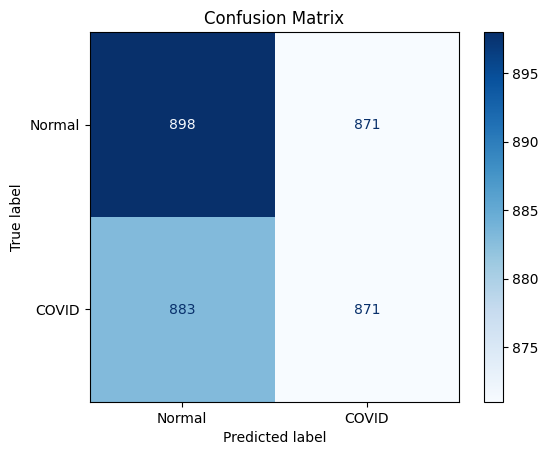

 Confusion matrix saved to confusion_matrix.png

 Evaluation Metrics:
Accuracy  : 0.5021
Precision : 0.5000
Recall    : 0.4966
F1 Score  : 0.4983


In [ ]:
import os
import pydicom
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage import filters, morphology
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.measure import regionprops, label
from scipy.stats import skew, kurtosis, entropy
import pywt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)

# Define the DICOM folder or single file (update as needed)
dicom_folder = '/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Moderate'  # For Colab

dicom_file = None  # Set to a single .dcm file path if folder is unavailable
feature_list = []

# Helper function to check Google Drive mount (for Colab)
def check_drive_mount():
    if not os.path.exists('/content/drive'):
        print(" Google Drive not mounted. Please mount it by running:")
        print("```python")
        print("from google.colab import drive")
        print("drive.mount('/content/drive')")
        print("```")
        return False
    return True

# Debugging: Check folder or file
print(f" Checking input: {dicom_folder if dicom_folder else dicom_file}")
use_single_file = False
if dicom_file and os.path.isfile(dicom_file):
    use_single_file = True
    print(f" Using single DICOM file: {dicom_file}")
elif dicom_folder:
    if not os.path.exists(dicom_folder):
        print(f" Error: Folder {dicom_folder} does not exist. Please verify the path.")
        if 'drive' in dicom_folder:
            check_drive_mount()
    else:
        dicom_files = [f for f in os.listdir(dicom_folder) if f.lower().endswith('.dcm')]
        print(f" Found {len(dicom_files)} DICOM files in {dicom_folder}:")
        if dicom_files:
            print(f" Sample files: {dicom_files[:5]} {'...' if len(dicom_files) > 5 else ''}")
        else:
            print(" No DICOM files found. Ensure the folder contains valid .dcm files.")
else:
    print(" Error: Please specify a valid dicom_folder or dicom_file.")

# Feature extraction function
def extract_features(dicom_path):
    try:
        # Read DICOM file
        ds = pydicom.dcmread(dicom_path, force=True)  # Force read to handle malformed files
        if not hasattr(ds, 'pixel_array'):
            print(f" No pixel data in {dicom_path}")
            return None

        image = ds.pixel_array.astype(np.float32)
        # Normalize image to [0, 1]
        image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-6)

        # Intensity Features
        mean_intensity = np.mean(image)
        std_intensity = np.std(image)
        max_intensity = np.max(image)
        min_intensity = max(np.min(image), 0.1)

        # Edge Feature
        mean_edge = np.mean(filters.sobel(image))

        # Thresholding for lung segmentation
        thresh = filters.threshold_otsu(image)
        lung_mask = morphology.remove_small_objects(image < thresh, min_size=500)
        lung_region = image[lung_mask]
        num_lung_pixels = lung_region.size
        num_white_pixels = np.sum(lung_region > np.percentile(lung_region, 90)) if num_lung_pixels > 0 else 0

        # GLCM Features
        image_uint8 = (image * 255).astype(np.uint8)
        glcm = graycomatrix(image_uint8, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
        glcm_features = [graycoprops(glcm, prop)[0, 0] for prop in ['contrast', 'correlation', 'energy', 'homogeneity']]

        # LBP Features
        lbp = local_binary_pattern(image_uint8, P=8, R=1, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10), density=True)
        lbp_mean = np.mean(lbp_hist)
        lbp_std = np.std(lbp_hist)

        # Wavelet Features
        LL, (LH, HL, HH) = pywt.dwt2(image, 'haar')
        wavelet_energy = np.sum(np.square(LH) + np.square(HL) + np.square(HH))
        wavelet_coeffs = np.array([np.sum(np.square(LH)), np.sum(np.square(HL)), np.sum(np.square(HH))])
        wavelet_probs = wavelet_coeffs / (np.sum(wavelet_coeffs) + 1e-6)  # Normalize for entropy
        wavelet_entropy = entropy(wavelet_probs)

        # Histogram Features
        hist, _ = np.histogram(image, bins=256, range=(0, 1), density=True)
        hist_entropy = entropy(hist + 1e-6)
        hist_skewness = skew(image.flatten())
        hist_kurtosis = kurtosis(image.flatten())

        # Morphological Features
        labeled_lung = label(lung_mask)
        props = regionprops(labeled_lung.astype(int))
        if props:
            largest_region = max(props, key=lambda x: x.area)
            lung_area = largest_region.area
            lung_perimeter = largest_region.perimeter
            eccentricity = largest_region.eccentricity
            solidity = largest_region.solidity
            extent = largest_region.extent
            minr, minc, maxr, maxc = largest_region.bbox
            bbox_ratio = (maxr - minr) / (maxc - minc + 1e-6)
        else:
            lung_area = lung_perimeter = eccentricity = solidity = extent = bbox_ratio = 0

        return [
            mean_intensity, std_intensity, max_intensity, min_intensity,
            mean_edge,
            num_lung_pixels, num_white_pixels,
            *glcm_features,  # Unpacks glcm_contrast, glcm_correlation, glcm_energy, glcm_homogeneity
            lbp_mean, lbp_std,
            wavelet_energy, wavelet_entropy,
            hist_entropy, hist_skewness, hist_kurtosis,
            lung_area, lung_perimeter, eccentricity, solidity, extent, bbox_ratio
        ]

    except Exception as e:
        print(f" Failed to process {dicom_path}: {str(e)}")
        return None

# Process DICOM files
if use_single_file and dicom_file:
    print(f" Processing single file: {dicom_file}")
    features = extract_features(dicom_file)
    if features:
        features.append(dicom_file)
        feature_list.append(features)
    else:
        print(f" Skipped {dicom_file} due to feature extraction failure")
elif dicom_folder and os.path.exists(dicom_folder):
    for root, dirs, files in os.walk(dicom_folder):
        dicom_files = [f for f in files if f.lower().endswith('.dcm')]
        if not dicom_files:
            print(f" No DICOM files found in {root}")
            continue
        for file in tqdm(dicom_files, desc=f"Processing DICOMs in {root}"):
            path = os.path.join(root, file)
            features = extract_features(path)
            if features:
                features.append(path)
                feature_list.append(features)
            else:
                print(f" Skipped {path} due to feature extraction failure")
else:
    print(" Cannot proceed: No valid folder or file specified.")

# Define feature columns
columns = [
    'mean_intensity', 'std_intensity', 'max_intensity', 'min_intensity',
    'mean_edge',
    'num_lung_pixels', 'num_white_pixels',
    'glcm_contrast', 'glcm_correlation', 'glcm_energy', 'glcm_homogeneity',
    'lbp_mean', 'lbp_std',
    'wavelet_energy', 'wavelet_entropy',
    'hist_entropy', 'hist_skewness', 'hist_kurtosis',
    'lung_area', 'lung_perimeter', 'eccentricity', 'solidity', 'extent', 'bbox_ratio',
    'dicom_path'
]

# Create and save DataFrame
if feature_list:
    df = pd.DataFrame(feature_list, columns=columns)
    print(" Feature extraction completed!")
    print("\n First 5 rows of extracted features:")
    print(df.head())

    # Save to CSV
    output_csv = 'dicom_features.csv'
    df.to_csv(output_csv, index=False)
    print(f" Features saved to {output_csv}")
else:
    print(" No valid features extracted. Check DICOM files or folder/file path.")
    df = pd.DataFrame()

# Print number of features
num_features = len(columns) - 1  # excluding dicom_path
print(f"\n Number of features extracted per DICOM image: {num_features}")

# Dummy evaluation with random labels
if not df.empty:
    np.random.seed(42)
    df['true_label'] = np.random.choice([0, 1], size=len(df))
    df['predicted_label'] = np.random.choice([0, 1], size=len(df))

    cm = confusion_matrix(df['true_label'], df['predicted_label'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "COVID"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.savefig('confusion_matrix.png')
    plt.show()
    print(f" Confusion matrix saved to confusion_matrix.png")

    print("\n Evaluation Metrics:")
    print(f"Accuracy  : {accuracy_score(df['true_label'], df['predicted_label']):.4f}")
    print(f"Precision : {precision_score(df['true_label'], df['predicted_label']):.4f}")
    print(f"Recall    : {recall_score(df['true_label'], df['predicted_label']):.4f}")
    print(f"F1 Score  : {f1_score(df['true_label'], df['predicted_label']):.4f}")
else:
    print(" Cannot perform evaluation: No data available.")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 125MB/s]


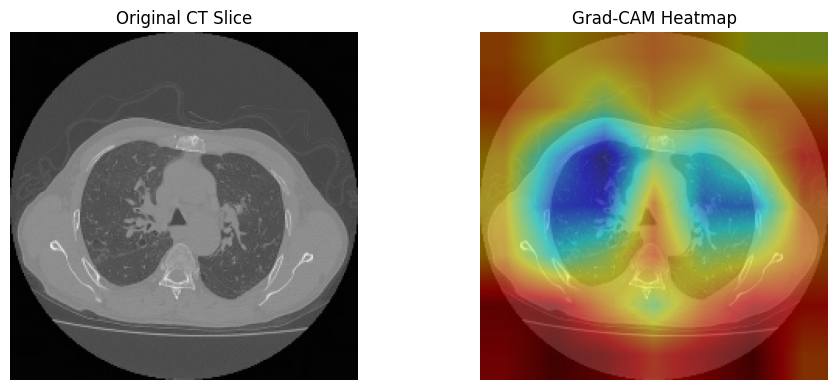

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pydicom

# Load DICOM image and convert to 3-channel PIL image
def load_dicom_as_rgb(path):
    dcm = pydicom.dcmread(path)
    image = dcm.pixel_array.astype(np.float32)
    image -= image.min()
    image /= image.max()
    image = (image * 255).astype(np.uint8)
    image = cv2.resize(image, (224, 224))
    rgb_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # 1-channel to 3-channel
    return Image.fromarray(rgb_image)

# Transform for VGG16 input
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Path to DICOM file
dicom_path = "/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal/P253/Series4/0780.dcm"
img = load_dicom_as_rgb(dicom_path)
input_tensor = transform(img).unsqueeze(0)

# Load pretrained VGG16
model = models.vgg16(pretrained=True)
model.eval()

# Hooks for Grad-CAM
gradients = []
activations = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

target_layer = model.features[-1]
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# Forward pass
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

# Backward pass
model.zero_grad()
class_score = output[0, pred_class]
class_score.backward()

# Grad-CAM computation
grads_val = gradients[0].detach().numpy()[0]
acts_val = activations[0].detach().numpy()[0]
weights = np.mean(grads_val, axis=(1, 2))

cam = np.zeros(acts_val.shape[1:], dtype=np.float32)
for i, w in enumerate(weights):
    cam += w * acts_val[i]

cam = np.maximum(cam, 0)
cam = cv2.resize(cam, (224, 224))
cam -= cam.min()
cam /= cam.max()

# Overlay heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
img_np = np.array(img.resize((224, 224)))
overlayed = cv2.addWeighted(img_np, 0.5, heatmap, 0.5, 0)

# Display
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original CT Slice")
plt.imshow(img_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(overlayed)
plt.axis('off')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


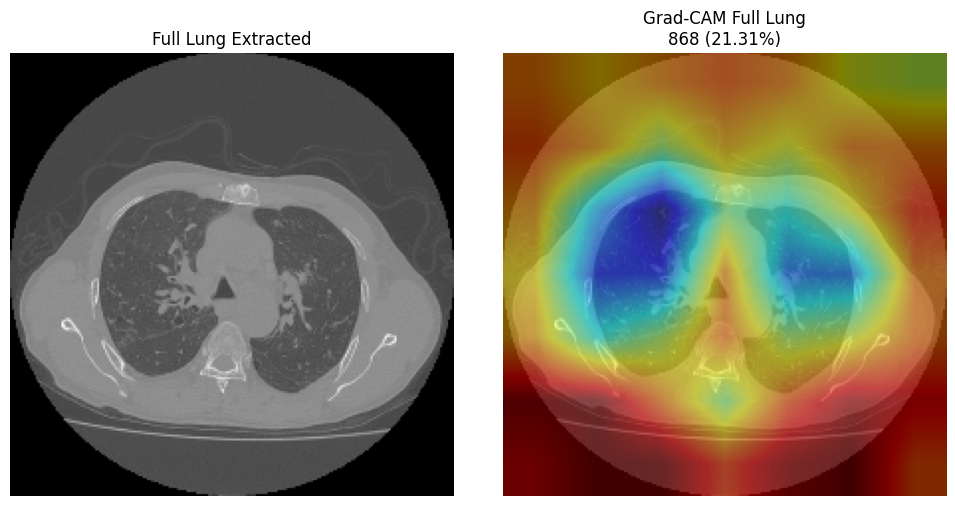

In [ ]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
import pydicom

# ---------- Helper: Load and preprocess DICOM ----------
def load_and_preprocess_dicom(path):
    dcm = pydicom.dcmread(path)
    image = dcm.pixel_array.astype(np.float32)
    image -= image.min()
    image /= image.max()
    image = (image * 255).astype(np.uint8)
    image = cv2.resize(image, (224, 224))
    lung_mask = (image > 30).astype(np.uint8)  # crude threshold for mask
    masked_image = image * lung_mask
    rgb_image = cv2.cvtColor(masked_image, cv2.COLOR_GRAY2RGB)
    return Image.fromarray(rgb_image), masked_image

# ---------- Grad-CAM for VGG16 ----------
def apply_grad_cam(img_pil, input_tensor, model, class_idx, target_layer):
    activations, gradients = [], []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    target_layer.register_forward_hook(forward_hook)
    target_layer.register_backward_hook(backward_hook)

    output = model(input_tensor)
    model.zero_grad()
    output[0, class_idx].backward()

    grads = gradients[0].detach().numpy()[0]
    acts = activations[0].detach().numpy()[0]
    weights = np.mean(grads, axis=(1, 2))
    cam = np.zeros(acts.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * acts[i]
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam -= cam.min()
    cam /= cam.max()

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    img_np = np.array(img_pil.resize((224, 224)))
    overlayed = cv2.addWeighted(img_np, 0.5, heatmap, 0.5, 0)
    return overlayed, cam

# ---------- Main Execution ----------
dicom_path = "/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal/P253/Series4/0780.dcm"
img_pil, lung_only_img = load_and_preprocess_dicom(dicom_path)

# Preprocess for model
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
input_tensor = transform(img_pil).unsqueeze(0)

# Load model
model = models.vgg16(pretrained=True)
model.eval()
target_layer = model.features[-1]

# Predicted class & confidence
output = model(input_tensor)
probabilities = torch.nn.functional.softmax(output[0], dim=0)
pred_class = torch.argmax(probabilities).item()
confidence = probabilities[pred_class].item() * 100

# Grad-CAM visualization
gradcam_overlay, _ = apply_grad_cam(img_pil, input_tensor, model, pred_class, target_layer)

# ---------- Final Plot ----------
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(lung_only_img, cmap='gray')
axs[0].set_title("Full Lung Extracted")
axs[0].axis('off')

axs[1].imshow(gradcam_overlay)
axs[1].set_title(f"Grad-CAM Full Lung\n{pred_class} ({confidence:.2f}%)")
axs[1].axis('off')

plt.tight_layout()
plt.show()


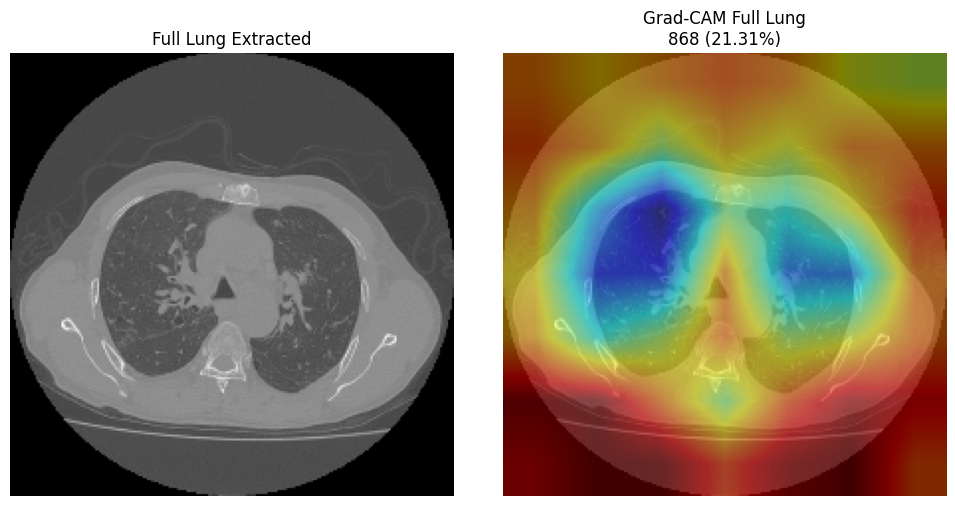

In [ ]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
import pydicom

# ---------- Helper: Load and preprocess DICOM ----------
def load_and_preprocess_dicom(path):
    dcm = pydicom.dcmread(path)
    image = dcm.pixel_array.astype(np.float32)
    image -= image.min()
    image /= image.max()
    image = (image * 255).astype(np.uint8)
    image = cv2.resize(image, (224, 224))
    lung_mask = (image > 30).astype(np.uint8)  # crude threshold for mask
    masked_image = image * lung_mask
    rgb_image = cv2.cvtColor(masked_image, cv2.COLOR_GRAY2RGB)
    return Image.fromarray(rgb_image), masked_image

# ---------- Grad-CAM for VGG16 ----------
def apply_grad_cam(img_pil, input_tensor, model, class_idx, target_layer):
    activations, gradients = [], []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    target_layer.register_forward_hook(forward_hook)
    target_layer.register_backward_hook(backward_hook)

    output = model(input_tensor)
    model.zero_grad()
    output[0, class_idx].backward()

    grads = gradients[0].detach().numpy()[0]
    acts = activations[0].detach().numpy()[0]
    weights = np.mean(grads, axis=(1, 2))
    cam = np.zeros(acts.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * acts[i]
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam -= cam.min()
    cam /= cam.max()

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    img_np = np.array(img_pil.resize((224, 224)))
    overlayed = cv2.addWeighted(img_np, 0.5, heatmap, 0.5, 0)
    return overlayed, cam

# ---------- Main Execution ----------
dicom_path = "/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal/P253/Series4/0780.dcm"
img_pil, lung_only_img = load_and_preprocess_dicom(dicom_path)

# Preprocess for model
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
input_tensor = transform(img_pil).unsqueeze(0)

# Load model
model = models.vgg16(pretrained=True)
model.eval()
target_layer = model.features[-1]

# Predicted class & confidence
output = model(input_tensor)
probabilities = torch.nn.functional.softmax(output[0], dim=0)
pred_class = torch.argmax(probabilities).item()
confidence = probabilities[pred_class].item() * 100

# Grad-CAM visualization
gradcam_overlay, _ = apply_grad_cam(img_pil, input_tensor, model, pred_class, target_layer)

# ---------- Final Plot ----------
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(lung_only_img, cmap='gray')
axs[0].set_title("Full Lung Extracted")
axs[0].axis('off')

axs[1].imshow(gradcam_overlay)
axs[1].set_title(f"Grad-CAM Full Lung\n{pred_class} ({confidence:.2f}%)")
axs[1].axis('off')

plt.tight_layout()
plt.show()


⚠️ Warning: RescaleIntercept/Slope not found in /content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal/image8.dcm.
 Using normalized pixel values for segmentation and display instead of HU.
 Using intensity thresholds (0.00, 0.64) for segmentation.


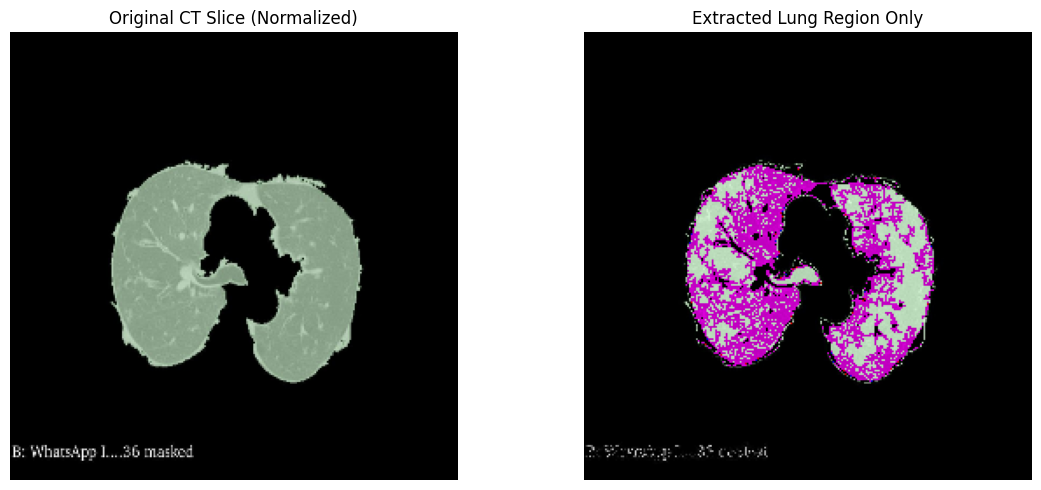

In [ ]:
import os
import numpy as np
import cv2
import pydicom
import matplotlib.pyplot as plt
from skimage import morphology
from scipy.ndimage import binary_fill_holes

# ---------------- Step 1: Load First DICOM File in Folder ----------------
dicom_folder = "/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal"
dicom_files = [f for f in os.listdir(dicom_folder) if f.endswith(".dcm")]

if not dicom_files:
    raise FileNotFoundError("❌ No DICOM files found in the specified folder.")

dicom_path = os.path.join(dicom_folder, dicom_files[0])
try:
    dicom_image = pydicom.dcmread(dicom_path, force=True) # Use force=True for robustness
except Exception as e:
    raise IOError(f"❌ Error reading DICOM file {dicom_path}: {e}")

if not hasattr(dicom_image, 'pixel_array'):
    raise ValueError(f"❌ DICOM file {dicom_path} does not contain pixel data.")

# ---------------- Step 2: Convert to Hounsfield Units (if possible) ----------------
image_array = dicom_image.pixel_array.astype(np.float32)

# Check if RescaleIntercept and RescaleSlope are present
if 'RescaleIntercept' in dicom_image and 'RescaleSlope' in dicom_image:
    intercept = dicom_image.RescaleIntercept
    slope = dicom_image.RescaleSlope
    hu_image = image_array * slope + intercept
    print(f"✅ Converted {dicom_path} to Hounsfield Units.")
    is_hu = True
else:
    # If rescaling tags are missing, work with the raw pixel array (normalized)
    print(f"⚠️ Warning: RescaleIntercept/Slope not found in {dicom_path}.")
    print(" Using normalized pixel values for segmentation and display instead of HU.")
    # Normalize the original array for segmentation and display
    if np.max(image_array) != np.min(image_array):
        hu_image = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array) + 1e-6)
    else:
        hu_image = image_array # Avoid divide-by-zero if flat
    is_hu = False


# ---------------- Step 3: Resize for Visualization ----------------
hu_resized = cv2.resize(hu_image, (256, 256), interpolation=cv2.INTER_LINEAR)

# ---------------- Step 4: Classical Lung Segmentation ----------------
# Adjust thresholds based on whether HU conversion was successful
if is_hu:
     # HU thresholds for lung window
     thresh_low = -950
     thresh_high = -400
     lung_mask = (hu_resized > thresh_low) & (hu_resized < thresh_high)
     print(f" Using HU thresholds ({thresh_low}, {thresh_high}) for segmentation.")
else:
     # Use intensity thresholds if HU not available (adjust these based on your normalized data)
     # These thresholds are examples and may need tuning for your specific dataset
     thresh_low = np.percentile(hu_resized.flatten(), 5)  # Example: lower 5th percentile
     thresh_high = np.percentile(hu_resized.flatten(), 95) # Example: upper 95th percentile
     lung_mask = (hu_resized > thresh_low) & (hu_resized < thresh_high)
     print(f" Using intensity thresholds ({thresh_low:.2f}, {thresh_high:.2f}) for segmentation.")


lung_mask_filled = binary_fill_holes(lung_mask)
lung_mask_cleaned = morphology.remove_small_objects(lung_mask_filled, min_size=1500)

# ---------------- Step 5: Extract Lung Region ----------------
# Apply the mask to the resized image (which is either HU or normalized pixel)
lung_only = hu_resized * lung_mask_cleaned

# Prepare image for display - always normalize the final 'lung_only' for consistent visualization
if np.max(lung_only) != np.min(lung_only):
    lung_display = (lung_only - np.min(lung_only)) / (np.max(lung_only) - np.min(lung_only) + 1e-6)
else:
    lung_display = lung_only # Avoid divide-by-zero if flat


# ---------------- Step 6: Display Results ----------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# Display the original resized image (either HU or normalized)
plt.imshow(hu_resized, cmap='gray')
plt.title(f"Original CT Slice ({'HU' if is_hu else 'Normalized'})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lung_display, cmap='gray')
plt.title("Extracted Lung Region Only")
plt.axis('off')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


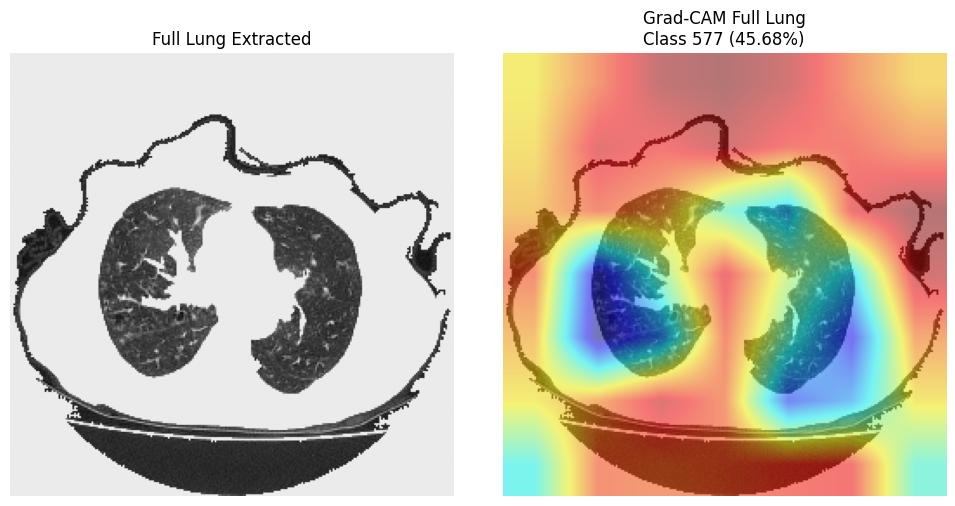

In [ ]:
import os
import numpy as np
import cv2
import pydicom
import matplotlib.pyplot as plt
from skimage import morphology
from scipy.ndimage import binary_fill_holes
import torch
from torchvision import models, transforms

# ---------------- Step 1: Load DICOM ----------------
dicom_path = "/content/drive/MyDrive/COVID-CT-DS/Original-DICOM/Normal/P253/Series4/0768.dcm"
dicom_image = pydicom.dcmread(dicom_path)
image_array = dicom_image.pixel_array.astype(np.float32)

intercept = dicom_image.RescaleIntercept
slope = dicom_image.RescaleSlope
hu_image = image_array * slope + intercept

# Resize to 256x256
hu_resized = cv2.resize(hu_image, (256, 256), interpolation=cv2.INTER_LINEAR)

# ---------------- Step 2: Classical Lung Segmentation ----------------
lung_mask = (hu_resized > -950) & (hu_resized < -400)
lung_mask = binary_fill_holes(lung_mask)
lung_mask = morphology.remove_small_objects(lung_mask, min_size=1500)

lung_only = hu_resized * lung_mask
lung_display = (lung_only - np.min(lung_only)) / (np.max(lung_only) - np.min(lung_only) + 1e-5)

# ---------------- Step 3: Prepare Image for CNN ----------------
lung_uint8 = (lung_display * 255).astype(np.uint8)
lung_rgb = cv2.cvtColor(lung_uint8, cv2.COLOR_GRAY2RGB)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
input_tensor = transform(lung_rgb).unsqueeze(0)

# ---------------- Step 4: Grad-CAM Setup ----------------
model = models.vgg16(pretrained=True)
model.eval()
target_layer = model.features[-1]

activations = []
gradients = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# Forward and backward pass
output = model(input_tensor)
probs = torch.nn.functional.softmax(output[0], dim=0)
pred_class = torch.argmax(probs).item()
confidence = probs[pred_class].item() * 100

model.zero_grad()
output[0, pred_class].backward()

# ---------------- Step 5: Generate Grad-CAM ----------------
grads_val = gradients[0].detach().numpy()[0]
acts_val = activations[0].detach().numpy()[0]
weights = np.mean(grads_val, axis=(1, 2))

cam = np.zeros(acts_val.shape[1:], dtype=np.float32)
for i, w in enumerate(weights):
    cam += w * acts_val[i]

cam = np.maximum(cam, 0)
cam = cv2.resize(cam, (256, 256))
cam -= cam.min()
cam /= (cam.max() + 1e-8)

# Overlay heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(lung_rgb, 0.5, heatmap, 0.5, 0)

# ---------------- Step 6: Display Like Reference ----------------
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(lung_display, cmap='gray')
plt.title("Full Lung Extracted")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title(f"Grad-CAM Full Lung\nClass {pred_class} ({confidence:.2f}%)")
plt.axis('off')

plt.tight_layout()
plt.show()
